In [31]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_squared_error
import sys
from pathlib import Path

# Zorg dat build_training_set ge√Ømporteerd is
current_dir = Path.cwd()
while current_dir.name != "ENEXIS" and current_dir.parent != current_dir:
    current_dir = current_dir.parent
project_root = current_dir
utils_path = project_root / "src" / "utils"
sys.path.append(str(utils_path))
from build_training_set import build_training_set

FEATURES = [
    'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation',
    'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day',
    'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday_cos'
]

target = 'Price'

# Initial training window
base_start = "2025-01-01 00:00:00"
base_end = "2025-03-14 23:00:00"
base_run = "2025-03-15 00:00:00"

rmse_results = []

print("üîç Testing Prophet Model - RMSE per forecast day")
print("=" * 60)

for i in range(30):
    start = pd.Timestamp(base_start) + pd.Timedelta(days=i)
    end = pd.Timestamp(base_end) + pd.Timedelta(days=i)
    run_date = pd.Timestamp(base_run) + pd.Timedelta(days=i)

    try:
        df = build_training_set(
            train_start=start.strftime("%Y-%m-%d %H:%M:%S"),
            train_end=end.strftime("%Y-%m-%d %H:%M:%S"),
            run_date=run_date.strftime("%Y-%m-%d %H:%M:%S")
        )

        if df is None or df.empty:
            print(f"Day {i+1}: ‚ùå No training data returned")
            continue

        df['target_datetime'] = pd.to_datetime(df['target_datetime'], utc=True)
        df = df.sort_values('target_datetime')

        run_date_utc = run_date.tz_localize("UTC")

        # Split into training and testing sets
        train_data = df[df['target_datetime'] <= run_date_utc]
        test_data = df[df['target_datetime'] > run_date_utc]

        # Drop any missing data in training
        train_data = train_data.dropna(subset=['target_datetime', target])

        if test_data.empty or train_data.empty:
            print(f"Day {i+1}: ‚ùå Not enough data for training or testing")
            continue

        # Prepare data for Prophet
        prophet_train = train_data.rename(columns={'target_datetime': 'ds', target: 'y'})[['ds', 'y'] + FEATURES]
        prophet_train['ds'] = prophet_train['ds'].dt.tz_localize(None)
        prophet_test = test_data.rename(columns={'target_datetime': 'ds', target: 'y'})[['ds', 'y'] + FEATURES]
        prophet_test['ds'] = prophet_test['ds'].dt.tz_localize(None)

        # Train Prophet model
        model = Prophet(daily_seasonality=True, yearly_seasonality=True, weekly_seasonality=True)
        model.fit(prophet_train)

        # Forecast for the test period
        future = prophet_test[['ds']]
        forecast = model.predict(future)
        y_pred = forecast['yhat'].values
        y_test = prophet_test['y'].values

        # Sla de eerste 24 uur over
        if len(y_pred) > 24:
            y_pred = y_pred[24:]
            y_test = y_test[24:]
        else:
            print("Niet genoeg testdata na lag van 24 uur.")
            rmse = np.nan
            rmse_results.append({
                'iteration': i + 1,
                'run_date': run_date.strftime('%Y-%m-%d'),
                'valid_predictions': 0,
                'rmse': rmse
            })
            continue

        if len(y_pred) > 0:
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        else:
            rmse = np.nan

        rmse_results.append({
            'iteration': i + 1,
            'run_date': run_date.strftime('%Y-%m-%d'),
            'valid_predictions': len(y_pred),
            'rmse': rmse
        })

        print(f"Day {i+1}: ‚úÖ {len(y_pred)} test rows, Run: {run_date.strftime('%m-%d')}")

    except Exception as e:
        print(f"Day {i+1}: ‚ùå Error: {e}")

# Create results dataframe
if rmse_results:
    rmse_df = pd.DataFrame(rmse_results)

    print(f"\nüìä OVERALL RMSE - Prophet Model")
    print("=" * 80)
    print(f"Successful runs: {rmse_df['rmse'].notna().sum()}/30")

    print(rmse_df[['iteration', 'run_date', 'valid_predictions', 'rmse']].round(2).to_string(index=False))

    print(f"\nüìà SUMMARY STATISTICS")
    print("-" * 40)
    print(rmse_df['rmse'].describe().round(2))

    print(f"\nüìä AVERAGE OVERALL RMSE")
    print("-" * 40)
    print(f"Mean RMSE: {rmse_df['rmse'].mean():.4f}")
    print(f"Stddev RMSE: {rmse_df['rmse'].std():.4f}")

else:
    print("‚ùå No runs completed successfully")

2025-05-31 19:14:43,883 - build_training_set - INFO - üìÖ Loading additional historical data until 2025-03-15 00:00:00+00:00 for lagging support
2025-05-31 19:14:43,890 - build_training_set - INFO - üöÄ Start build van trainingset
2025-05-31 19:14:43,896 - build_training_set - INFO - üß† Actuals van 2025-01-01 00:00:00+00:00 t/m 2025-03-14 23:00:00+00:00 (extended to 2025-03-15 00:00:00+00:00 for lagging)
2025-05-31 19:14:43,900 - build_training_set - INFO - üìÖ Forecast van run_date 2025-03-15 00:00:00+00:00, normalized to 2025-03-15 00:00:00+00:00 for DB lookup, target range: 2025-03-15 00:00:00+00:00 ‚Üí 2025-03-22 00:00:00+00:00
2025-05-31 19:14:43,902 - build_training_set - INFO - üì• Loading actuals with selected columns only...
2025-05-31 19:14:43,906 - build_training_set - INFO - üìã Requested columns found: 21/21
2025-05-31 19:14:43,906 - build_training_set - INFO - üìã Using columns: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_

üîç Testing Prophet Model - RMSE per forecast day


2025-05-31 19:14:44,106 - build_training_set - INFO -    ‚úÖ Added Load: 169/169 values found
2025-05-31 19:14:44,107 - build_training_set - INFO -    üïê Lagging column 'Flow_NO' by 168 hours
2025-05-31 19:14:44,204 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:14:44,205 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:14:44,297 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:14:44,298 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:14:44,299 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:14:44,303 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:14:44,347 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:14:44,348 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025

Day 1: ‚úÖ 144 test rows, Run: 03-15


2025-05-31 19:14:45,259 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:14:45,260 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:14:45,334 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:14:45,336 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:14:45,337 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:14:45,340 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:14:45,380 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:14:45,381 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:14:45,383 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:14:45,387 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 2: ‚úÖ 144 test rows, Run: 03-16


2025-05-31 19:14:46,344 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:14:46,345 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:14:46,423 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:14:46,424 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:14:46,425 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:14:46,429 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:14:46,472 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:14:46,473 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:14:46,476 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:14:46,480 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 3: ‚úÖ 144 test rows, Run: 03-17


2025-05-31 19:14:47,290 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:14:47,290 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:14:47,368 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:14:47,369 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:14:47,370 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:14:47,374 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:14:47,414 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:14:47,415 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:14:47,417 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:14:47,421 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 4: ‚úÖ 144 test rows, Run: 03-18


2025-05-31 19:14:48,084 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:14:48,085 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:14:48,163 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:14:48,165 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:14:48,165 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:14:48,169 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:14:48,208 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:14:48,209 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:14:48,213 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:14:48,216 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 5: ‚úÖ 144 test rows, Run: 03-19


2025-05-31 19:14:48,832 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:14:48,833 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:14:48,909 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:14:48,911 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:14:48,912 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:14:48,915 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:14:48,954 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:14:48,955 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:14:48,957 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:14:48,960 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 6: ‚úÖ 144 test rows, Run: 03-20


2025-05-31 19:14:49,692 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:14:49,693 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:14:49,784 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:14:49,785 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:14:49,786 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:14:49,790 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:14:49,835 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:14:49,836 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:14:49,838 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:14:49,841 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 7: ‚úÖ 144 test rows, Run: 03-21


2025-05-31 19:14:50,564 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:14:50,565 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:14:50,648 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:14:50,649 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:14:50,650 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:14:50,655 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:14:50,715 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:14:50,716 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:14:50,721 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:14:50,724 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 8: ‚úÖ 144 test rows, Run: 03-22


2025-05-31 19:14:51,400 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:14:51,401 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:14:51,476 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:14:51,478 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:14:51,479 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:14:51,482 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:14:51,523 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:14:51,523 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:14:51,526 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:14:51,529 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 9: ‚úÖ 144 test rows, Run: 03-23


2025-05-31 19:14:52,199 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:14:52,199 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:14:52,275 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:14:52,276 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:14:52,276 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:14:52,281 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:14:52,322 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:14:52,323 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:14:52,325 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:14:52,328 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 10: ‚úÖ 144 test rows, Run: 03-24


2025-05-31 19:14:53,075 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:14:53,076 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:14:53,151 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:14:53,152 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:14:53,153 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:14:53,156 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:14:53,196 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:14:53,197 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:14:53,199 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:14:53,202 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 11: ‚úÖ 144 test rows, Run: 03-25


2025-05-31 19:14:53,880 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:14:53,880 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:14:53,957 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:14:53,958 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:14:53,959 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:14:53,963 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:14:54,001 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:14:54,003 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:14:54,005 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:14:54,008 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 12: ‚úÖ 144 test rows, Run: 03-26


2025-05-31 19:14:54,704 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:14:54,705 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:14:54,781 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:14:54,783 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:14:54,783 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:14:54,787 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:14:54,825 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:14:54,826 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:14:54,828 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:14:54,831 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 13: ‚úÖ 144 test rows, Run: 03-27


2025-05-31 19:14:55,493 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:14:55,493 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:14:55,607 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:14:55,609 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:14:55,609 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:14:55,614 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:14:55,653 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:14:55,654 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:14:55,656 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:14:55,661 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 14: ‚úÖ 144 test rows, Run: 03-28


2025-05-31 19:14:56,424 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:14:56,424 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:14:56,499 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:14:56,501 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:14:56,502 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:14:56,506 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:14:56,545 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:14:56,546 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:14:56,548 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:14:56,552 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 15: ‚úÖ 144 test rows, Run: 03-29


2025-05-31 19:14:57,242 - build_training_set - INFO -    ‚úÖ Added Load: 169/169 values found
2025-05-31 19:14:57,243 - build_training_set - INFO -    üïê Lagging column 'Flow_NO' by 168 hours
2025-05-31 19:14:57,317 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:14:57,318 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:14:57,391 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:14:57,393 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:14:57,395 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:14:57,399 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:14:57,439 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:14:57,440 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025

Day 16: ‚úÖ 144 test rows, Run: 03-30


2025-05-31 19:14:58,271 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:14:58,271 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:14:58,347 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:14:58,349 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:14:58,350 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:14:58,354 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:14:58,395 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:14:58,396 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:14:58,397 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:14:58,401 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 17: ‚úÖ 144 test rows, Run: 03-31


2025-05-31 19:14:59,416 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:14:59,417 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:14:59,494 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:14:59,496 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:14:59,496 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:14:59,500 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:14:59,539 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:14:59,540 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:14:59,542 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:14:59,547 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 18: ‚úÖ 144 test rows, Run: 04-01


2025-05-31 19:15:00,362 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:15:00,364 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:15:00,438 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:15:00,440 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:15:00,440 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:15:00,444 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:15:00,484 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:15:00,485 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:15:00,488 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:15:00,491 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 19: ‚úÖ 144 test rows, Run: 04-02


2025-05-31 19:15:01,138 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:15:01,138 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:15:01,214 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:15:01,216 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:15:01,216 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:15:01,220 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:15:01,258 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:15:01,260 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:15:01,263 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:15:01,266 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 20: ‚úÖ 144 test rows, Run: 04-03


2025-05-31 19:15:02,031 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:15:02,032 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:15:02,109 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:15:02,111 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:15:02,113 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:15:02,116 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:15:02,160 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:15:02,161 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:15:02,167 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:15:02,171 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 21: ‚úÖ 144 test rows, Run: 04-04


2025-05-31 19:15:02,849 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:15:02,850 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:15:02,930 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:15:02,931 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:15:02,931 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:15:02,935 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:15:02,976 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:15:02,978 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:15:02,980 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:15:02,983 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 22: ‚úÖ 144 test rows, Run: 04-05


2025-05-31 19:15:03,634 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:15:03,635 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:15:03,716 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:15:03,717 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:15:03,719 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:15:03,723 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:15:03,768 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:15:03,772 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:15:03,774 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:15:03,782 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 23: ‚úÖ 144 test rows, Run: 04-06


2025-05-31 19:15:04,387 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:15:04,387 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:15:04,467 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:15:04,469 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:15:04,470 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:15:04,474 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:15:04,515 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:15:04,516 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:15:04,520 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:15:04,523 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 24: ‚úÖ 144 test rows, Run: 04-07


2025-05-31 19:15:05,372 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:15:05,373 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:15:05,451 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:15:05,453 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:15:05,454 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:15:05,457 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:15:05,497 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:15:05,498 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:15:05,501 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:15:05,505 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 25: ‚úÖ 144 test rows, Run: 04-08


2025-05-31 19:15:06,132 - build_training_set - INFO -    ‚úÖ Added Load: 169/169 values found
2025-05-31 19:15:06,133 - build_training_set - INFO -    üïê Lagging column 'Flow_NO' by 168 hours
2025-05-31 19:15:06,208 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:15:06,209 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:15:06,281 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:15:06,282 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:15:06,282 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:15:06,286 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:15:06,325 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:15:06,326 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025

Day 26: ‚úÖ 144 test rows, Run: 04-09


2025-05-31 19:15:06,906 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:15:06,907 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:15:06,982 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:15:06,983 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:15:06,983 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:15:06,987 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:15:07,027 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:15:07,028 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:15:07,031 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:15:07,034 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 27: ‚úÖ 144 test rows, Run: 04-10


2025-05-31 19:15:07,630 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:15:07,631 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:15:07,708 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:15:07,710 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:15:07,711 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:15:07,714 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:15:07,753 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:15:07,754 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:15:07,756 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:15:07,759 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 28: ‚úÖ 144 test rows, Run: 04-11


2025-05-31 19:15:08,449 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:15:08,450 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:15:08,526 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:15:08,528 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:15:08,529 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:15:08,532 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:15:08,572 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:15:08,573 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:15:08,575 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:15:08,579 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 29: ‚úÖ 144 test rows, Run: 04-12


2025-05-31 19:15:09,124 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:15:09,125 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:15:09,200 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:15:09,201 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:15:09,202 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:15:09,206 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:15:09,245 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:15:09,246 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:15:09,249 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:15:09,253 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 30: ‚úÖ 144 test rows, Run: 04-13

üìä OVERALL RMSE - Prophet Model
Successful runs: 30/30
 iteration   run_date  valid_predictions  rmse
         1 2025-03-15                144  0.14
         2 2025-03-16                144  0.13
         3 2025-03-17                144  0.11
         4 2025-03-18                144  0.07
         5 2025-03-19                144  0.04
         6 2025-03-20                144  0.04
         7 2025-03-21                144  0.04
         8 2025-03-22                144  0.05
         9 2025-03-23                144  0.05
        10 2025-03-24                144  0.05
        11 2025-03-25                144  0.12
        12 2025-03-26                144  0.12
        13 2025-03-27                144  0.11
        14 2025-03-28                144  0.05
        15 2025-03-29                144  0.06
        16 2025-03-30                144  0.10
        17 2025-03-31                144  0.23
        18 2025-04-01                144  0.08
        19 

In [32]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_squared_error
import sys
from pathlib import Path

# Zorg dat build_training_set ge√Ømporteerd is
current_dir = Path.cwd()
while current_dir.name != "ENEXIS" and current_dir.parent != current_dir:
    current_dir = current_dir.parent
project_root = current_dir
utils_path = project_root / "src" / "utils"
sys.path.append(str(utils_path))
from build_training_set import build_training_set

FEATURES = [
    'Load', 'shortwave_radiation', 'temperature_2m', 
    'direct_normal_irradiance', 'diffuse_radiation', 
    'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 
    'yearday_sin', 'wind_speed_10m', 'is_non_working_day', 
    'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 
    'hour_sin', 'weekday_cos'
]
target = 'Price'

# Initial training window
base_start = "2025-01-01 00:00:00"
base_end = "2025-03-14 23:00:00"
base_run = "2025-03-15 00:00:00"

rmse_results = []

print("üîç Testing Prophet Model - RMSE per forecast day")
print("=" * 60)

for i in range(30):
    start = pd.Timestamp(base_start) + pd.Timedelta(days=i)
    end = pd.Timestamp(base_end) + pd.Timedelta(days=i)
    run_date = pd.Timestamp(base_run) + pd.Timedelta(days=i)

    try:
        df = build_training_set(
            train_start=start.strftime("%Y-%m-%d %H:%M:%S"),
            train_end=end.strftime("%Y-%m-%d %H:%M:%S"),
            run_date=run_date.strftime("%Y-%m-%d %H:%M:%S")
        )

        if df is None or df.empty:
            print(f"Day {i+1}: ‚ùå No training data returned")
            continue

        df['target_datetime'] = pd.to_datetime(df['target_datetime'], utc=True)
        df = df.sort_values('target_datetime')

        run_date_utc = run_date.tz_localize("UTC")

        # Split into training and testing sets
        train_data = df[df['target_datetime'] <= run_date_utc]
        test_data = df[df['target_datetime'] > run_date_utc]

        # Drop any missing data in training and test
        train_data = train_data.dropna(subset=['target_datetime', target] + FEATURES)
        test_data = test_data.dropna(subset=['target_datetime', target] + FEATURES)

        if test_data.empty or train_data.empty:
            print(f"Day {i+1}: ‚ùå Not enough data for training or testing")
            continue

        # Prepare data for Prophet
        prophet_train = train_data.rename(columns={'target_datetime': 'ds', target: 'y'})[['ds', 'y'] + FEATURES]
        prophet_train['ds'] = prophet_train['ds'].dt.tz_localize(None)
        prophet_test = test_data.rename(columns={'target_datetime': 'ds', target: 'y'})[['ds', 'y'] + FEATURES]
        prophet_test['ds'] = prophet_test['ds'].dt.tz_localize(None)

        # Train Prophet model with extra regressors
        model = Prophet(daily_seasonality=True, yearly_seasonality=True, weekly_seasonality=True)
        for reg in FEATURES:
            model.add_regressor(reg)
        model.fit(prophet_train)

        # Forecast for the test period
        future = prophet_test[['ds'] + FEATURES]
        forecast = model.predict(future)
        y_pred = forecast['yhat'].values
        y_test = prophet_test['y'].values

        # Sla de eerste 24 uur over
        if len(y_pred) > 24:
            y_pred = y_pred[24:]
            y_test = y_test[24:]
        else:
            print("Niet genoeg testdata na lag van 24 uur.")
            rmse = np.nan
            rmse_results.append({
                'iteration': i + 1,
                'run_date': run_date.strftime('%Y-%m-%d'),
                'valid_predictions': 0,
                'rmse': rmse
            })
            continue

        if len(y_pred) > 0:
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        else:
            rmse = np.nan

        rmse_results.append({
            'iteration': i + 1,
            'run_date': run_date.strftime('%Y-%m-%d'),
            'valid_predictions': len(y_pred),
            'rmse': rmse
        })

        print(f"Day {i+1}: ‚úÖ {len(y_pred)} test rows, Run: {run_date.strftime('%m-%d')}")

    except Exception as e:
        print(f"Day {i+1}: ‚ùå Error: {e}")

# Create results dataframe
if rmse_results:
    rmse_df = pd.DataFrame(rmse_results)

    print(f"\nüìä OVERALL RMSE - Prophet Model")
    print("=" * 80)
    print(f"Successful runs: {rmse_df['rmse'].notna().sum()}/30")

    print(rmse_df[['iteration', 'run_date', 'valid_predictions', 'rmse']].round(2).to_string(index=False))

    print(f"\nüìà SUMMARY STATISTICS")
    print("-" * 40)
    print(rmse_df['rmse'].describe().round(2))

    print(f"\nüìä AVERAGE OVERALL RMSE")
    print("-" * 40)
    print(f"Mean RMSE: {rmse_df['rmse'].mean():.4f}")
    print(f"Stddev RMSE: {rmse_df['rmse'].std():.4f}")

else:
    print("‚ùå No runs completed successfully")
  

2025-05-31 19:15:09,640 - build_training_set - INFO - üìÖ Loading additional historical data until 2025-03-15 00:00:00+00:00 for lagging support
2025-05-31 19:15:09,641 - build_training_set - INFO - üöÄ Start build van trainingset
2025-05-31 19:15:09,645 - build_training_set - INFO - üß† Actuals van 2025-01-01 00:00:00+00:00 t/m 2025-03-14 23:00:00+00:00 (extended to 2025-03-15 00:00:00+00:00 for lagging)
2025-05-31 19:15:09,647 - build_training_set - INFO - üìÖ Forecast van run_date 2025-03-15 00:00:00+00:00, normalized to 2025-03-15 00:00:00+00:00 for DB lookup, target range: 2025-03-15 00:00:00+00:00 ‚Üí 2025-03-22 00:00:00+00:00
2025-05-31 19:15:09,648 - build_training_set - INFO - üì• Loading actuals with selected columns only...
2025-05-31 19:15:09,652 - build_training_set - INFO - üìã Requested columns found: 21/21
2025-05-31 19:15:09,652 - build_training_set - INFO - üìã Using columns: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_

üîç Testing Prophet Model - RMSE per forecast day


2025-05-31 19:15:09,865 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:15:09,865 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:15:09,939 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:15:09,940 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:15:09,941 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:15:09,946 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:15:09,987 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:15:09,988 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:15:09,990 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:15:09,993 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 1: ‚úÖ 144 test rows, Run: 03-15


2025-05-31 19:15:10,860 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:15:10,862 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:15:10,935 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:15:10,936 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:15:10,937 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:15:10,940 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:15:10,979 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:15:10,980 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:15:10,982 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:15:10,986 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 2: ‚úÖ 144 test rows, Run: 03-16


2025-05-31 19:15:11,768 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:15:11,769 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:15:11,845 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:15:11,846 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:15:11,846 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:15:11,850 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:15:11,889 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:15:11,890 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:15:11,892 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:15:11,895 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 3: ‚úÖ 144 test rows, Run: 03-17


2025-05-31 19:15:12,853 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:15:12,854 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:15:12,929 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:15:12,930 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:15:12,931 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:15:12,934 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:15:12,974 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:15:12,975 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:15:12,978 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:15:12,980 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 4: ‚úÖ 144 test rows, Run: 03-18


2025-05-31 19:15:13,955 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:15:13,956 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:15:14,033 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:15:14,034 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:15:14,034 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:15:14,039 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:15:14,078 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:15:14,079 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:15:14,081 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:15:14,084 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 5: ‚úÖ 144 test rows, Run: 03-19


2025-05-31 19:15:15,022 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:15:15,022 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:15:15,098 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:15:15,099 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:15:15,100 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:15:15,103 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:15:15,142 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:15:15,143 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:15:15,145 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:15:15,149 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 6: ‚úÖ 144 test rows, Run: 03-20


2025-05-31 19:15:16,052 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:15:16,053 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:15:16,130 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:15:16,131 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:15:16,132 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:15:16,135 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:15:16,174 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:15:16,175 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:15:16,178 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:15:16,181 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 7: ‚úÖ 144 test rows, Run: 03-21


2025-05-31 19:15:16,973 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:15:16,974 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:15:17,051 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:15:17,052 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:15:17,053 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:15:17,057 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:15:17,096 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:15:17,097 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:15:17,100 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:15:17,103 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 8: ‚úÖ 144 test rows, Run: 03-22


2025-05-31 19:15:17,828 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:15:17,828 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:15:17,904 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:15:17,905 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:15:17,905 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:15:17,909 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:15:17,948 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:15:17,949 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:15:17,951 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:15:17,954 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 9: ‚úÖ 144 test rows, Run: 03-23


2025-05-31 19:15:18,732 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:15:18,733 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:15:18,807 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:15:18,809 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:15:18,809 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:15:18,813 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:15:18,853 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:15:18,854 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:15:18,856 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:15:18,859 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 10: ‚úÖ 144 test rows, Run: 03-24


2025-05-31 19:15:19,884 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:15:19,894 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:15:19,984 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:15:19,985 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:15:19,987 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:15:19,990 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:15:20,030 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:15:20,031 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:15:20,032 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:15:20,036 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 11: ‚úÖ 144 test rows, Run: 03-25


2025-05-31 19:15:20,958 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:15:20,958 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:15:21,034 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:15:21,036 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:15:21,037 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:15:21,040 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:15:21,080 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:15:21,081 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:15:21,082 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:15:21,086 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 12: ‚úÖ 144 test rows, Run: 03-26


2025-05-31 19:15:21,837 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:15:21,838 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:15:21,914 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:15:21,915 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:15:21,916 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:15:21,920 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:15:21,958 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:15:21,959 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:15:21,962 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:15:21,964 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 13: ‚úÖ 144 test rows, Run: 03-27


2025-05-31 19:15:22,739 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:15:22,739 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:15:22,814 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:15:22,815 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:15:22,815 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:15:22,819 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:15:22,858 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:15:22,859 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:15:22,861 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:15:22,865 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 14: ‚úÖ 144 test rows, Run: 03-28


2025-05-31 19:15:23,747 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:15:23,748 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:15:23,822 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:15:23,823 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:15:23,824 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:15:23,828 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:15:23,867 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:15:23,868 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:15:23,870 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:15:23,873 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 15: ‚úÖ 144 test rows, Run: 03-29


2025-05-31 19:15:24,726 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:15:24,727 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:15:24,802 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:15:24,804 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:15:24,804 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:15:24,808 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:15:24,846 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:15:24,847 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:15:24,849 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:15:24,852 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 16: ‚úÖ 144 test rows, Run: 03-30


2025-05-31 19:15:25,825 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:15:25,825 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:15:25,947 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:15:25,950 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:15:25,950 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:15:25,955 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:15:26,005 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:15:26,006 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:15:26,008 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:15:26,011 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 17: ‚úÖ 144 test rows, Run: 03-31


2025-05-31 19:15:27,130 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:15:27,130 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:15:27,206 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:15:27,207 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:15:27,208 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:15:27,211 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:15:27,250 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:15:27,251 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:15:27,254 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:15:27,257 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 18: ‚úÖ 144 test rows, Run: 04-01


2025-05-31 19:15:28,130 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:15:28,131 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:15:28,206 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:15:28,207 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:15:28,208 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:15:28,212 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:15:28,250 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:15:28,252 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:15:28,253 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:15:28,257 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 19: ‚úÖ 144 test rows, Run: 04-02


2025-05-31 19:15:29,087 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:15:29,088 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:15:29,162 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:15:29,163 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:15:29,164 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:15:29,167 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:15:29,206 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:15:29,214 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:15:29,217 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:15:29,221 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 20: ‚úÖ 144 test rows, Run: 04-03


2025-05-31 19:15:30,283 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:15:30,284 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:15:30,361 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:15:30,363 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:15:30,363 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:15:30,367 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:15:30,407 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:15:30,408 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:15:30,410 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:15:30,413 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 21: ‚úÖ 144 test rows, Run: 04-04


2025-05-31 19:15:31,367 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:15:31,368 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:15:31,455 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:15:31,456 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:15:31,457 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:15:31,460 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:15:31,500 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:15:31,501 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:15:31,504 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:15:31,507 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 22: ‚úÖ 144 test rows, Run: 04-05


2025-05-31 19:15:32,364 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:15:32,365 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:15:32,442 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:15:32,443 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:15:32,444 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:15:32,447 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:15:32,485 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:15:32,486 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:15:32,489 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:15:32,492 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 23: ‚úÖ 144 test rows, Run: 04-06


2025-05-31 19:15:33,575 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:15:33,575 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:15:33,655 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:15:33,656 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:15:33,657 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:15:33,660 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:15:33,701 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:15:33,702 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:15:33,704 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:15:33,707 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 24: ‚úÖ 144 test rows, Run: 04-07


2025-05-31 19:15:34,468 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:15:34,469 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:15:34,546 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:15:34,548 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:15:34,548 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:15:34,552 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:15:34,591 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:15:34,592 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:15:34,595 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:15:34,598 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 25: ‚úÖ 144 test rows, Run: 04-08


2025-05-31 19:15:35,350 - build_training_set - INFO -    ‚úÖ Added Load: 169/169 values found
2025-05-31 19:15:35,350 - build_training_set - INFO -    üïê Lagging column 'Flow_NO' by 168 hours
2025-05-31 19:15:35,424 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:15:35,424 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:15:35,498 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:15:35,500 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:15:35,502 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:15:35,507 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:15:35,548 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:15:35,549 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025

Day 26: ‚úÖ 144 test rows, Run: 04-09


2025-05-31 19:15:36,359 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:15:36,359 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:15:36,440 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:15:36,442 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:15:36,443 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:15:36,449 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:15:36,504 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:15:36,505 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:15:36,507 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:15:36,512 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 27: ‚úÖ 144 test rows, Run: 04-10


2025-05-31 19:15:37,366 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:15:37,367 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:15:37,445 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:15:37,446 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:15:37,447 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:15:37,450 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:15:37,489 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:15:37,490 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:15:37,492 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:15:37,496 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 28: ‚úÖ 144 test rows, Run: 04-11


2025-05-31 19:15:38,350 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:15:38,350 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:15:38,428 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:15:38,430 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:15:38,431 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:15:38,434 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:15:38,473 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:15:38,474 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:15:38,475 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:15:38,478 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 29: ‚úÖ 144 test rows, Run: 04-12


2025-05-31 19:15:39,351 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:15:39,353 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:15:39,429 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:15:39,430 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:15:39,430 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:15:39,434 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:15:39,472 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:15:39,473 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:15:39,475 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:15:39,479 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 30: ‚úÖ 144 test rows, Run: 04-13

üìä OVERALL RMSE - Prophet Model
Successful runs: 30/30
 iteration   run_date  valid_predictions  rmse
         1 2025-03-15                144  0.04
         2 2025-03-16                144  0.05
         3 2025-03-17                144  0.04
         4 2025-03-18                144  0.03
         5 2025-03-19                144  0.03
         6 2025-03-20                144  0.03
         7 2025-03-21                144  0.05
         8 2025-03-22                144  0.03
         9 2025-03-23                144  0.04
        10 2025-03-24                144  0.06
        11 2025-03-25                144  0.07
        12 2025-03-26                144  0.06
        13 2025-03-27                144  0.03
        14 2025-03-28                144  0.07
        15 2025-03-29                144  0.10
        16 2025-03-30                144  0.16
        17 2025-03-31                144  0.23
        18 2025-04-01                144  0.10
        19 

All Execution runs combined

In [33]:
import time
from datetime import datetime

FEATURES = [
    'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation',
    'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day',
    'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday_cos'
]
target = 'Price'

#'Load', 'shortwave_radiation', 'temperature_2m', 
#    'Flow_NO', 'yearday_cos', 'Flow_GB', 
#    'yearday_sin', 
#    'hour_sin']
    

# wind_speed_10m

# Initial training window
base_start = "2025-01-01 00:00:00"
base_end = "2025-03-14 23:00:00"
base_run = "2025-03-15 00:00:00"

rmse_results = []
results = []

###### Base Model Run

print("üîç Testing Prophet Model as base run")
print("=" * 60)

model_run_start_time = time.time()

for i in range(30):
    start = pd.Timestamp(base_start) + pd.Timedelta(days=i)
    end = pd.Timestamp(base_end) + pd.Timedelta(days=i)
    run_date = pd.Timestamp(base_run) + pd.Timedelta(days=i)

    try:
        df = build_training_set(
            train_start=start.strftime("%Y-%m-%d %H:%M:%S"),
            train_end=end.strftime("%Y-%m-%d %H:%M:%S"),
            run_date=run_date.strftime("%Y-%m-%d %H:%M:%S")
        )

        if df is None or df.empty:
            print(f"Day {i+1}: ‚ùå No training data returned")
            continue

        df['target_datetime'] = pd.to_datetime(df['target_datetime'], utc=True)
        df = df.sort_values('target_datetime')

        run_date_utc = run_date.tz_localize("UTC")

        # Split into training and testing sets
        train_data = df[df['target_datetime'] <= run_date_utc]
        test_data = df[df['target_datetime'] > run_date_utc]

        # Drop any missing data in training and test
        train_data = train_data.dropna(subset=['target_datetime', target])
        test_data = test_data.dropna(subset=['target_datetime', target])

        if test_data.empty or train_data.empty:
            print(f"Day {i+1}: ‚ùå Not enough data for training or testing")
            continue

        # Prepare data for Prophet
        prophet_train = train_data.rename(columns={'target_datetime': 'ds', target: 'y'})[['ds', 'y']]
        prophet_train['ds'] = prophet_train['ds'].dt.tz_localize(None)
        prophet_test = test_data.rename(columns={'target_datetime': 'ds', target: 'y'})[['ds', 'y']]
        prophet_test['ds'] = prophet_test['ds'].dt.tz_localize(None)

        # Train Prophet model with extra regressors
        model = Prophet(daily_seasonality=True, yearly_seasonality=True, weekly_seasonality=True)
        model.fit(prophet_train)

        # Forecast for the test period
        future = prophet_test[['ds']]
        forecast = model.predict(future)
        y_pred = forecast['yhat'].values
        y_test = prophet_test['y'].values

        # Sla de eerste 24 uur over
        if len(y_pred) > 24:
            y_pred = y_pred[24:]
            y_test = y_test[24:]
        else:
            print("Niet genoeg testdata na lag van 24 uur.")
            rmse = np.nan
            rmse_results.append({
                'iteration': i + 1,
                'run_date': run_date.strftime('%Y-%m-%d'),
                'valid_predictions': 0,
                'rmse': rmse
            })
            continue

        if len(y_pred) > 0:
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        else:
            rmse = np.nan

        rmse_results.append({
            'iteration': i + 1,
            'run_date': run_date.strftime('%Y-%m-%d'),
            'valid_predictions': len(y_pred),
            'rmse': rmse
        })

        print(f"Day {i+1}: ‚úÖ {len(y_pred)} test rows, Run: {run_date.strftime('%m-%d')}")

    except Exception as e:
        print(f"Day {i+1}: ‚ùå Error: {e}")

# Create results dataframe
if rmse_results:
    rmse_df = pd.DataFrame(rmse_results)

    print(f"\nüìä OVERALL RMSE - Prophet Model")
    print("=" * 80)
    print(f"Successful runs: {rmse_df['rmse'].notna().sum()}/30")

    print(rmse_df[['iteration', 'run_date', 'valid_predictions', 'rmse']].round(2).to_string(index=False))

    print(f"\nüìà SUMMARY STATISTICS")
    print("-" * 40)
    print(rmse_df['rmse'].describe().round(2))

    print(f"\nüìä AVERAGE OVERALL RMSE")
    print("-" * 40)
    print(f"Mean RMSE: {rmse_df['rmse'].mean():.4f}")
    print(f"Stddev RMSE: {rmse_df['rmse'].std():.4f}")

else:
    print("‚ùå No runs completed successfully")

model_run_end_time = time.time()
execution_time = model_run_end_time - model_run_start_time

comments = "Base model run on 31st May with rolling df"
model_run_timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
results.append(["Prophet", rmse, comments, execution_time, model_run_timestamp])
metrics_df = pd.DataFrame(results, columns=["Model", "RMSE", "Comments", "Execution Time", "Run At"])


####### Time Features

print("üîç Testing Prophet Model Time features - RMSE per forecast day")
print("=" * 60)

TIME_FEATURES = [
    'Load', 'weekday_cos', 'weekday_sin', 'hour_cos', 'hour_sin', 'yearday_cos', 'yearday_sin'
]

model_run_start_time = time.time()

for i in range(30):
    start = pd.Timestamp(base_start) + pd.Timedelta(days=i)
    end = pd.Timestamp(base_end) + pd.Timedelta(days=i)
    run_date = pd.Timestamp(base_run) + pd.Timedelta(days=i)

    try:
        df = build_training_set(
            train_start=start.strftime("%Y-%m-%d %H:%M:%S"),
            train_end=end.strftime("%Y-%m-%d %H:%M:%S"),
            run_date=run_date.strftime("%Y-%m-%d %H:%M:%S")
        )

        if df is None or df.empty:
            print(f"Day {i+1}: ‚ùå No training data returned")
            continue

        df['target_datetime'] = pd.to_datetime(df['target_datetime'], utc=True)
        df = df.sort_values('target_datetime')

        run_date_utc = run_date.tz_localize("UTC")

        # Split into training and testing sets
        train_data = df[df['target_datetime'] <= run_date_utc]
        test_data = df[df['target_datetime'] > run_date_utc]

        # Drop any missing data in training and test
        train_data = train_data.dropna(subset=['target_datetime', target] + TIME_FEATURES)
        test_data = test_data.dropna(subset=['target_datetime', target] + TIME_FEATURES)

        if test_data.empty or train_data.empty:
            print(f"Day {i+1}: ‚ùå Not enough data for training or testing")
            continue

        # Prepare data for Prophet
        prophet_train = train_data.rename(columns={'target_datetime': 'ds', target: 'y'})[['ds', 'y'] + TIME_FEATURES]
        prophet_train['ds'] = prophet_train['ds'].dt.tz_localize(None)
        prophet_test = test_data.rename(columns={'target_datetime': 'ds', target: 'y'})[['ds', 'y'] + TIME_FEATURES]
        prophet_test['ds'] = prophet_test['ds'].dt.tz_localize(None)

        # Train Prophet model with extra regressors
        model = Prophet(daily_seasonality=True, yearly_seasonality=True, weekly_seasonality=True)
        for reg in TIME_FEATURES:
            model.add_regressor(reg)
        model.fit(prophet_train)

        # Forecast for the test period
        future = prophet_test[['ds'] + TIME_FEATURES]
        forecast = model.predict(future)
        y_pred = forecast['yhat'].values
        y_test = prophet_test['y'].values

        # Sla de eerste 24 uur over
        if len(y_pred) > 24:
            y_pred = y_pred[24:]
            y_test = y_test[24:]
        else:
            print("Niet genoeg testdata na lag van 24 uur.")
            rmse = np.nan
            rmse_results.append({
                'iteration': i + 1,
                'run_date': run_date.strftime('%Y-%m-%d'),
                'valid_predictions': 0,
                'rmse': rmse
            })
            continue

        if len(y_pred) > 0:
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        else:
            rmse = np.nan

        rmse_results.append({
            'iteration': i + 1,
            'run_date': run_date.strftime('%Y-%m-%d'),
            'valid_predictions': len(y_pred),
            'rmse': rmse
        })

        print(f"Day {i+1}: ‚úÖ {len(y_pred)} test rows, Run: {run_date.strftime('%m-%d')}")

    except Exception as e:
        print(f"Day {i+1}: ‚ùå Error: {e}")

# Create results dataframe
if rmse_results:
    rmse_df = pd.DataFrame(rmse_results)

    print(f"\nüìä OVERALL RMSE - Prophet Model")
    print("=" * 80)
    print(f"Successful runs: {rmse_df['rmse'].notna().sum()}/30")

    print(rmse_df[['iteration', 'run_date', 'valid_predictions', 'rmse']].round(2).to_string(index=False))

    print(f"\nüìà SUMMARY STATISTICS")
    print("-" * 40)
    print(rmse_df['rmse'].describe().round(2))

    print(f"\nüìä AVERAGE OVERALL RMSE")
    print("-" * 40)
    print(f"Mean RMSE: {rmse_df['rmse'].mean():.4f}")
    print(f"Stddev RMSE: {rmse_df['rmse'].std():.4f}")

else:
    print("‚ùå No runs completed successfully")

model_run_end_time = time.time()
execution_time = model_run_end_time - model_run_start_time

comments = "Base model run on 31st May with time features"
model_run_timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
results.append(["Prophet", rmse, comments, execution_time, model_run_timestamp])
metrics_df = pd.DataFrame(results, columns=["Model", "RMSE", "Comments", "Execution Time", "Run At"])


####### All features

print("üîç Testing Prophet Model with all selected features")
print("=" * 60)

model_run_start_time = time.time()

for i in range(30):
    start = pd.Timestamp(base_start) + pd.Timedelta(days=i)
    end = pd.Timestamp(base_end) + pd.Timedelta(days=i)
    run_date = pd.Timestamp(base_run) + pd.Timedelta(days=i)

    try:
        df = build_training_set(
            train_start=start.strftime("%Y-%m-%d %H:%M:%S"),
            train_end=end.strftime("%Y-%m-%d %H:%M:%S"),
            run_date=run_date.strftime("%Y-%m-%d %H:%M:%S")
        )

        if df is None or df.empty:
            print(f"Day {i+1}: ‚ùå No training data returned")
            continue

        df['target_datetime'] = pd.to_datetime(df['target_datetime'], utc=True)
        df = df.sort_values('target_datetime')

        run_date_utc = run_date.tz_localize("UTC")

        # Split into training and testing sets
        train_data = df[df['target_datetime'] <= run_date_utc]
        test_data = df[df['target_datetime'] > run_date_utc]

        # Drop any missing data in training and test
        train_data = train_data.dropna(subset=['target_datetime', target] + FEATURES)
        test_data = test_data.dropna(subset=['target_datetime', target] + FEATURES)

        if test_data.empty or train_data.empty:
            print(f"Day {i+1}: ‚ùå Not enough data for training or testing")
            continue

        # Prepare data for Prophet
        prophet_train = train_data.rename(columns={'target_datetime': 'ds', target: 'y'})[['ds', 'y'] + FEATURES]
        prophet_train['ds'] = prophet_train['ds'].dt.tz_localize(None)
        prophet_test = test_data.rename(columns={'target_datetime': 'ds', target: 'y'})[['ds', 'y'] + FEATURES]
        prophet_test['ds'] = prophet_test['ds'].dt.tz_localize(None)

        # Train Prophet model with extra regressors
        model = Prophet(daily_seasonality=True, yearly_seasonality=True, weekly_seasonality=True)
        for reg in FEATURES:
            model.add_regressor(reg)
        model.fit(prophet_train)

        # Forecast for the test period
        future = prophet_test[['ds'] + FEATURES]
        forecast = model.predict(future)
        y_pred = forecast['yhat'].values
        y_test = prophet_test['y'].values

        # Sla de eerste 24 uur over
        if len(y_pred) > 24:
            y_pred = y_pred[24:]
            y_test = y_test[24:]
        else:
            print("Niet genoeg testdata na lag van 24 uur.")
            rmse = np.nan
            rmse_results.append({
                'iteration': i + 1,
                'run_date': run_date.strftime('%Y-%m-%d'),
                'valid_predictions': 0,
                'rmse': rmse
            })
            continue

        if len(y_pred) > 0:
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        else:
            rmse = np.nan

        rmse_results.append({
            'iteration': i + 1,
            'run_date': run_date.strftime('%Y-%m-%d'),
            'valid_predictions': len(y_pred),
            'rmse': rmse
        })

        print(f"Day {i+1}: ‚úÖ {len(y_pred)} test rows, Run: {run_date.strftime('%m-%d')}")

    except Exception as e:
        print(f"Day {i+1}: ‚ùå Error: {e}")

# Create results dataframe
if rmse_results:
    rmse_df = pd.DataFrame(rmse_results)

    print(f"\nüìä OVERALL RMSE - Prophet Model")
    print("=" * 80)
    print(f"Successful runs: {rmse_df['rmse'].notna().sum()}/30")

    print(rmse_df[['iteration', 'run_date', 'valid_predictions', 'rmse']].round(2).to_string(index=False))

    print(f"\nüìà SUMMARY STATISTICS")
    print("-" * 40)
    print(rmse_df['rmse'].describe().round(2))

    print(f"\nüìä AVERAGE OVERALL RMSE")
    print("-" * 40)
    print(f"Mean RMSE: {rmse_df['rmse'].mean():.4f}")
    print(f"Stddev RMSE: {rmse_df['rmse'].std():.4f}")

else:
    print("‚ùå No runs completed successfully")

model_run_end_time = time.time()
execution_time = model_run_end_time - model_run_start_time

comments = "Base model run on 31st May with all features"
model_run_timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
results.append(["Prophet", rmse, comments, execution_time, model_run_timestamp])
metrics_df = pd.DataFrame(results, columns=["Model", "RMSE", "Comments", "Execution Time", "Run At"])




######## Top 10 Features

print("üîç Testing Prophet Model Top 10 features - RMSE per forecast day")
print("=" * 60)

TOP_10_FEATURES = [
    'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance',
    'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst'
]


model_run_start_time = time.time()

for i in range(30):
    start = pd.Timestamp(base_start) + pd.Timedelta(days=i)
    end = pd.Timestamp(base_end) + pd.Timedelta(days=i)
    run_date = pd.Timestamp(base_run) + pd.Timedelta(days=i)

    try:
        df = build_training_set(
            train_start=start.strftime("%Y-%m-%d %H:%M:%S"),
            train_end=end.strftime("%Y-%m-%d %H:%M:%S"),
            run_date=run_date.strftime("%Y-%m-%d %H:%M:%S")
        )

        if df is None or df.empty:
            print(f"Day {i+1}: ‚ùå No training data returned")
            continue

        df['target_datetime'] = pd.to_datetime(df['target_datetime'], utc=True)
        df = df.sort_values('target_datetime')

        run_date_utc = run_date.tz_localize("UTC")

        # Split into training and testing sets
        train_data = df[df['target_datetime'] <= run_date_utc]
        test_data = df[df['target_datetime'] > run_date_utc]

        # Drop any missing data in training and test
        train_data = train_data.dropna(subset=['target_datetime', target] + TOP_10_FEATURES)
        test_data = test_data.dropna(subset=['target_datetime', target] + TOP_10_FEATURES)

        if test_data.empty or train_data.empty:
            print(f"Day {i+1}: ‚ùå Not enough data for training or testing")
            continue

        # Prepare data for Prophet
        prophet_train = train_data.rename(columns={'target_datetime': 'ds', target: 'y'})[['ds', 'y'] + TOP_10_FEATURES]
        prophet_train['ds'] = prophet_train['ds'].dt.tz_localize(None)
        prophet_test = test_data.rename(columns={'target_datetime': 'ds', target: 'y'})[['ds', 'y'] + TOP_10_FEATURES]
        prophet_test['ds'] = prophet_test['ds'].dt.tz_localize(None)

        # Train Prophet model with extra regressors
        model = Prophet(daily_seasonality=True, yearly_seasonality=True, weekly_seasonality=True)
        for reg in TOP_10_FEATURES:
            model.add_regressor(reg)
        model.fit(prophet_train)

        # Forecast for the test period
        future = prophet_test[['ds'] + TOP_10_FEATURES]
        forecast = model.predict(future)
        y_pred = forecast['yhat'].values
        y_test = prophet_test['y'].values

        # Sla de eerste 24 uur over
        if len(y_pred) > 24:
            y_pred = y_pred[24:]
            y_test = y_test[24:]
        else:
            print("Niet genoeg testdata na lag van 24 uur.")
            rmse = np.nan
            rmse_results.append({
                'iteration': i + 1,
                'run_date': run_date.strftime('%Y-%m-%d'),
                'valid_predictions': 0,
                'rmse': rmse
            })
            continue

        if len(y_pred) > 0:
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        else:
            rmse = np.nan

        rmse_results.append({
            'iteration': i + 1,
            'run_date': run_date.strftime('%Y-%m-%d'),
            'valid_predictions': len(y_pred),
            'rmse': rmse
        })

        print(f"Day {i+1}: ‚úÖ {len(y_pred)} test rows, Run: {run_date.strftime('%m-%d')}")

    except Exception as e:
        print(f"Day {i+1}: ‚ùå Error: {e}")

# Create results dataframe
if rmse_results:
    rmse_df = pd.DataFrame(rmse_results)

    print(f"\nüìä OVERALL RMSE - Prophet Model")
    print("=" * 80)
    print(f"Successful runs: {rmse_df['rmse'].notna().sum()}/30")

    print(rmse_df[['iteration', 'run_date', 'valid_predictions', 'rmse']].round(2).to_string(index=False))

    print(f"\nüìà SUMMARY STATISTICS")
    print("-" * 40)
    print(rmse_df['rmse'].describe().round(2))

    print(f"\nüìä AVERAGE OVERALL RMSE")
    print("-" * 40)
    print(f"Mean RMSE: {rmse_df['rmse'].mean():.4f}")
    print(f"Stddev RMSE: {rmse_df['rmse'].std():.4f}")

else:
    print("‚ùå No runs completed successfully")

model_run_end_time = time.time()
execution_time = model_run_end_time - model_run_start_time

comments = "Base model run on 31st May with 10 features"
model_run_timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
results.append(["Prophet", rmse, comments, execution_time, model_run_timestamp])
metrics_df = pd.DataFrame(results, columns=["Model", "RMSE", "Comments", "Execution Time", "Run At"])


######## Top 6 Features

print("üîç Testing Prophet Model Top 6 features - RMSE per forecast day")
print("=" * 60)

TOP_6_FEATURES = [
    'Load','shortwave_radiation','temperature_2m','direct_normal_irradiance','diffuse_radiation','Flow_NO'
]

model_run_start_time = time.time()

for i in range(30):
    start = pd.Timestamp(base_start) + pd.Timedelta(days=i)
    end = pd.Timestamp(base_end) + pd.Timedelta(days=i)
    run_date = pd.Timestamp(base_run) + pd.Timedelta(days=i)

    try:
        df = build_training_set(
            train_start=start.strftime("%Y-%m-%d %H:%M:%S"),
            train_end=end.strftime("%Y-%m-%d %H:%M:%S"),
            run_date=run_date.strftime("%Y-%m-%d %H:%M:%S")
        )

        if df is None or df.empty:
            print(f"Day {i+1}: ‚ùå No training data returned")
            continue

        df['target_datetime'] = pd.to_datetime(df['target_datetime'], utc=True)
        df = df.sort_values('target_datetime')

        run_date_utc = run_date.tz_localize("UTC")

        # Split into training and testing sets
        train_data = df[df['target_datetime'] <= run_date_utc]
        test_data = df[df['target_datetime'] > run_date_utc]

        # Drop any missing data in training and test
        train_data = train_data.dropna(subset=['target_datetime', target] + TOP_6_FEATURES)
        test_data = test_data.dropna(subset=['target_datetime', target] + TOP_6_FEATURES)

        if test_data.empty or train_data.empty:
            print(f"Day {i+1}: ‚ùå Not enough data for training or testing")
            continue

        # Prepare data for Prophet
        prophet_train = train_data.rename(columns={'target_datetime': 'ds', target: 'y'})[['ds', 'y'] + TOP_6_FEATURES]
        prophet_train['ds'] = prophet_train['ds'].dt.tz_localize(None)
        prophet_test = test_data.rename(columns={'target_datetime': 'ds', target: 'y'})[['ds', 'y'] + TOP_6_FEATURES]
        prophet_test['ds'] = prophet_test['ds'].dt.tz_localize(None)

        # Train Prophet model with extra regressors
        model = Prophet(daily_seasonality=True, yearly_seasonality=True, weekly_seasonality=True)
        for reg in TOP_6_FEATURES:
            model.add_regressor(reg)
        model.fit(prophet_train)

        # Forecast for the test period
        future = prophet_test[['ds'] + TOP_6_FEATURES]
        forecast = model.predict(future)
        y_pred = forecast['yhat'].values
        y_test = prophet_test['y'].values

        # Sla de eerste 24 uur over
        if len(y_pred) > 24:
            y_pred = y_pred[24:]
            y_test = y_test[24:]
        else:
            print("Niet genoeg testdata na lag van 24 uur.")
            rmse = np.nan
            rmse_results.append({
                'iteration': i + 1,
                'run_date': run_date.strftime('%Y-%m-%d'),
                'valid_predictions': 0,
                'rmse': rmse
            })
            continue

        if len(y_pred) > 0:
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        else:
            rmse = np.nan

        rmse_results.append({
            'iteration': i + 1,
            'run_date': run_date.strftime('%Y-%m-%d'),
            'valid_predictions': len(y_pred),
            'rmse': rmse
        })

        print(f"Day {i+1}: ‚úÖ {len(y_pred)} test rows, Run: {run_date.strftime('%m-%d')}")

    except Exception as e:
        print(f"Day {i+1}: ‚ùå Error: {e}")

# Create results dataframe
if rmse_results:
    rmse_df = pd.DataFrame(rmse_results)

    print(f"\nüìä OVERALL RMSE - Prophet Model")
    print("=" * 80)
    print(f"Successful runs: {rmse_df['rmse'].notna().sum()}/30")

    print(rmse_df[['iteration', 'run_date', 'valid_predictions', 'rmse']].round(2).to_string(index=False))

    print(f"\nüìà SUMMARY STATISTICS")
    print("-" * 40)
    print(rmse_df['rmse'].describe().round(2))

    print(f"\nüìä AVERAGE OVERALL RMSE")
    print("-" * 40)
    print(f"Mean RMSE: {rmse_df['rmse'].mean():.4f}")
    print(f"Stddev RMSE: {rmse_df['rmse'].std():.4f}")

else:
    print("‚ùå No runs completed successfully")

model_run_end_time = time.time()
execution_time = model_run_end_time - model_run_start_time

comments = "Base model run on 31st May with rolling df"
model_run_timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
results.append(["Prophet", rmse, comments, execution_time, model_run_timestamp])
metrics_df = pd.DataFrame(results, columns=["Model", "RMSE", "Comments", "Execution Time", "Run At"])


######## Top 4 Features

print("üîç Testing Prophet Model Top 4 features - RMSE per forecast day")
print("=" * 60)

TOP_4_FEATURES = [
    'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance'
]

model_run_start_time = time.time()

for i in range(30):
    start = pd.Timestamp(base_start) + pd.Timedelta(days=i)
    end = pd.Timestamp(base_end) + pd.Timedelta(days=i)
    run_date = pd.Timestamp(base_run) + pd.Timedelta(days=i)

    try:
        df = build_training_set(
            train_start=start.strftime("%Y-%m-%d %H:%M:%S"),
            train_end=end.strftime("%Y-%m-%d %H:%M:%S"),
            run_date=run_date.strftime("%Y-%m-%d %H:%M:%S")
        )

        if df is None or df.empty:
            print(f"Day {i+1}: ‚ùå No training data returned")
            continue

        df['target_datetime'] = pd.to_datetime(df['target_datetime'], utc=True)
        df = df.sort_values('target_datetime')

        run_date_utc = run_date.tz_localize("UTC")

        # Split into training and testing sets
        train_data = df[df['target_datetime'] <= run_date_utc]
        test_data = df[df['target_datetime'] > run_date_utc]

        # Drop any missing data in training and test
        train_data = train_data.dropna(subset=['target_datetime', target] + TOP_4_FEATURES)
        test_data = test_data.dropna(subset=['target_datetime', target] + TOP_4_FEATURES)

        if test_data.empty or train_data.empty:
            print(f"Day {i+1}: ‚ùå Not enough data for training or testing")
            continue

        # Prepare data for Prophet
        prophet_train = train_data.rename(columns={'target_datetime': 'ds', target: 'y'})[['ds', 'y'] + TOP_4_FEATURES]
        prophet_train['ds'] = prophet_train['ds'].dt.tz_localize(None)
        prophet_test = test_data.rename(columns={'target_datetime': 'ds', target: 'y'})[['ds', 'y'] + TOP_4_FEATURES]
        prophet_test['ds'] = prophet_test['ds'].dt.tz_localize(None)

        # Train Prophet model with extra regressors
        model = Prophet(daily_seasonality=True, yearly_seasonality=True, weekly_seasonality=True)
        for reg in TOP_4_FEATURES:
            model.add_regressor(reg)
        model.fit(prophet_train)

        # Forecast for the test period
        future = prophet_test[['ds'] + TOP_4_FEATURES]
        forecast = model.predict(future)
        y_pred = forecast['yhat'].values
        y_test = prophet_test['y'].values

        # Sla de eerste 24 uur over
        if len(y_pred) > 24:
            y_pred = y_pred[24:]
            y_test = y_test[24:]
        else:
            print("Niet genoeg testdata na lag van 24 uur.")
            rmse = np.nan
            rmse_results.append({
                'iteration': i + 1,
                'run_date': run_date.strftime('%Y-%m-%d'),
                'valid_predictions': 0,
                'rmse': rmse
            })
            continue

        if len(y_pred) > 0:
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        else:
            rmse = np.nan

        rmse_results.append({
            'iteration': i + 1,
            'run_date': run_date.strftime('%Y-%m-%d'),
            'valid_predictions': len(y_pred),
            'rmse': rmse
        })

        print(f"Day {i+1}: ‚úÖ {len(y_pred)} test rows, Run: {run_date.strftime('%m-%d')}")

    except Exception as e:
        print(f"Day {i+1}: ‚ùå Error: {e}")

# Create results dataframe
if rmse_results:
    rmse_df = pd.DataFrame(rmse_results)

    print(f"\nüìä OVERALL RMSE - Prophet Model")
    print("=" * 80)
    print(f"Successful runs: {rmse_df['rmse'].notna().sum()}/30")

    print(rmse_df[['iteration', 'run_date', 'valid_predictions', 'rmse']].round(2).to_string(index=False))

    print(f"\nüìà SUMMARY STATISTICS")
    print("-" * 40)
    print(rmse_df['rmse'].describe().round(2))

    print(f"\nüìä AVERAGE OVERALL RMSE")
    print("-" * 40)
    print(f"Mean RMSE: {rmse_df['rmse'].mean():.4f}")
    print(f"Stddev RMSE: {rmse_df['rmse'].std():.4f}")

else:
    print("‚ùå No runs completed successfully")

model_run_end_time = time.time()
execution_time = model_run_end_time - model_run_start_time

comments = "Base model run on 31st May with rolling df"
model_run_timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
results.append(["Prophet", rmse, comments, execution_time, model_run_timestamp])
metrics_df = pd.DataFrame(results, columns=["Model", "RMSE", "Comments", "Execution Time", "Run At"])





###### Run for the BEST param

from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import itertools
import numpy as np
import pandas as pd
import os
import joblib
from datetime import datetime, timedelta

# -------------------- SETUP --------------------

# Define regressors
regressors = [
    'Load','shortwave_radiation','temperature_2m','direct_normal_irradiance','diffuse_radiation',
    'Flow_NO','yearday_cos','Flow_GB','month','is_dst','yearday_sin','is_non_working_day',
    'hour_cos','is_weekend','cloud_cover','weekday_sin','hour_sin','weekday_cos'
]


available_regressors = [col for col in train_data.columns if col in regressors]

# Parameter grid
# Reduced hyperparameter grid for faster grid search
param_grid = {
    'seasonality_mode': ['additive','multiplicative'],
    'changepoint_prior_scale': [0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.1, 1.0, 5.0, 10.0],
    'holidays_prior_scale': [0.1, 1.0],
    'changepoint_range': [0.8],
    'n_changepoints': [25, 50]
}
"""
param_grid = {
    'changepoint_prior_scale': [0.5],
    'seasonality_mode': ['additive'],
    'seasonality_prior_scale': [1.0],
    'holidays_prior_scale': [1.0],
    'changepoint_range': [0.8]
}
"""

all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

# -------------------- HYPERPARAMETER TUNING --------------------

best_rmse = float('inf')
best_model = None
best_forecast = None
best_params = None

# Prepare data for Prophet
prophet_train = train_data.rename(columns={'target_datetime': 'ds', target: 'y'})[['ds', 'y'] + FEATURES]
prophet_train['ds'] = prophet_train['ds'].dt.tz_localize(None)
prophet_test = test_data.rename(columns={'target_datetime': 'ds', target: 'y'})[['ds', 'y'] + FEATURES]
prophet_test['ds'] = prophet_test['ds'].dt.tz_localize(None)

for params in all_params:
    model = Prophet(**params)
    #for reg in available_regressors:
    for reg in FEATURES:
        model.add_regressor(reg)
    model.fit(prophet_train)
    
    forecast = model.predict(prophet_test)
    y_true = prophet_test['y'].values
    y_pred = forecast['yhat'].values
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    if rmse < best_rmse:
        best_rmse = rmse
        best_model = model
        best_forecast = forecast
        best_params = params

print(f"‚úÖ Best Parameters: {best_params}")
print(f"‚úÖ Best RMSE: {best_rmse:.3f}")



####### All features with best params

print("üîç Testing Prophet Model with all selected features and best params")
print("=" * 60)

#2025-05-31 16:10:13,834 - warp-prophet-model - INFO - ‚úÖ Best Parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 
# 'seasonality_prior_scale': 5.0, 'holidays_prior_scale': 1.0, 'changepoint_range': 0.8, 'n_changepoints': 50}

best_param_grid = {
    'seasonality_mode': ['additive'],
    'changepoint_prior_scale': [0.01],
    'seasonality_prior_scale': [5.0],
    'holidays_prior_scale': [1.0],
    'changepoint_range': [0.8],
    'n_changepoints': [50],
    'daily_seasonality': [True],
    'weekly_seasonality': [True],
    'yearly_seasonality': [True]
}

model_run_start_time = time.time()

for i in range(30):
    start = pd.Timestamp(base_start) + pd.Timedelta(days=i)
    end = pd.Timestamp(base_end) + pd.Timedelta(days=i)
    run_date = pd.Timestamp(base_run) + pd.Timedelta(days=i)

    try:
        df = build_training_set(
            train_start=start.strftime("%Y-%m-%d %H:%M:%S"),
            train_end=end.strftime("%Y-%m-%d %H:%M:%S"),
            run_date=run_date.strftime("%Y-%m-%d %H:%M:%S")
        )

        if df is None or df.empty:
            print(f"Day {i+1}: ‚ùå No training data returned")
            continue

        df['target_datetime'] = pd.to_datetime(df['target_datetime'], utc=True)
        df = df.sort_values('target_datetime')

        run_date_utc = run_date.tz_localize("UTC")

        # Split into training and testing sets
        train_data = df[df['target_datetime'] <= run_date_utc]
        test_data = df[df['target_datetime'] > run_date_utc]

        # Drop any missing data in training and test
        train_data = train_data.dropna(subset=['target_datetime', target] + FEATURES)
        test_data = test_data.dropna(subset=['target_datetime', target] + FEATURES)

        if test_data.empty or train_data.empty:
            print(f"Day {i+1}: ‚ùå Not enough data for training or testing")
            continue

        # Prepare data for Prophet
        prophet_train = train_data.rename(columns={'target_datetime': 'ds', target: 'y'})[['ds', 'y'] + FEATURES]
        prophet_train['ds'] = prophet_train['ds'].dt.tz_localize(None)
        prophet_test = test_data.rename(columns={'target_datetime': 'ds', target: 'y'})[['ds', 'y'] + FEATURES]
        prophet_test['ds'] = prophet_test['ds'].dt.tz_localize(None)

        # Train Prophet model with extra regressors
        """
        model = Prophet(
            changepoint_prior_scale=params['changepoint_prior_scale'],
            seasonality_mode=params['seasonality_mode'],
            seasonality_prior_scale=params['seasonality_prior_scale'],
            holidays_prior_scale=params['holidays_prior_scale'],
            changepoint_range=params['changepoint_range'],
            n_changepoints=params['n_changepoints'],
            daily_seasonality=params.get('daily_seasonality', True),
            weekly_seasonality=params.get('weekly_seasonality', True),
            yearly_seasonality=params.get('yearly_seasonality', True)
        )

        for reg in FEATURES:
            model.add_regressor(reg)
        model.fit(prophet_train)
        """

        forecast = best_model.predict(prophet_test)

        # Forecast for the test period
        future = prophet_test[['ds'] + FEATURES]
        forecast = model.predict(future)
        y_pred = forecast['yhat'].values
        y_test = prophet_test['y'].values

        # Sla de eerste 24 uur over
        if len(y_pred) > 24:
            y_pred = y_pred[24:]
            y_test = y_test[24:]
        else:
            print("Niet genoeg testdata na lag van 24 uur.")
            rmse = np.nan
            rmse_results.append({
                'iteration': i + 1,
                'run_date': run_date.strftime('%Y-%m-%d'),
                'valid_predictions': 0,
                'rmse': rmse
            })
            continue

        if len(y_pred) > 0:
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        else:
            rmse = np.nan

        rmse_results.append({
            'iteration': i + 1,
            'run_date': run_date.strftime('%Y-%m-%d'),
            'valid_predictions': len(y_pred),
            'rmse': rmse
        })

        print(f"Day {i+1}: ‚úÖ {len(y_pred)} test rows, Run: {run_date.strftime('%m-%d')}")

    except Exception as e:
        print(f"Day {i+1}: ‚ùå Error: {e}")

# Create results dataframe
if rmse_results:
    rmse_df = pd.DataFrame(rmse_results)

    print(f"\nüìä OVERALL RMSE - Prophet Model")
    print("=" * 80)
    print(f"Successful runs: {rmse_df['rmse'].notna().sum()}/30")

    print(rmse_df[['iteration', 'run_date', 'valid_predictions', 'rmse']].round(2).to_string(index=False))

    print(f"\nüìà SUMMARY STATISTICS")
    print("-" * 40)
    print(rmse_df['rmse'].describe().round(2))

    print(f"\nüìä AVERAGE OVERALL RMSE")
    print("-" * 40)
    print(f"Mean RMSE: {rmse_df['rmse'].mean():.4f}")
    print(f"Stddev RMSE: {rmse_df['rmse'].std():.4f}")

else:
    print("‚ùå No runs completed successfully")

model_run_end_time = time.time()
execution_time = model_run_end_time - model_run_start_time

comments = "Base model run on 31st May with all features and best hyperparameters"
model_run_timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
results.append(["Prophet", rmse, comments, execution_time, model_run_timestamp])
metrics_df = pd.DataFrame(results, columns=["Model", "RMSE", "Comments", "Execution Time", "Run At"])

2025-05-31 19:15:40,224 - build_training_set - INFO - üìÖ Loading additional historical data until 2025-03-15 00:00:00+00:00 for lagging support
2025-05-31 19:15:40,225 - build_training_set - INFO - üöÄ Start build van trainingset
2025-05-31 19:15:40,229 - build_training_set - INFO - üß† Actuals van 2025-01-01 00:00:00+00:00 t/m 2025-03-14 23:00:00+00:00 (extended to 2025-03-15 00:00:00+00:00 for lagging)
2025-05-31 19:15:40,230 - build_training_set - INFO - üìÖ Forecast van run_date 2025-03-15 00:00:00+00:00, normalized to 2025-03-15 00:00:00+00:00 for DB lookup, target range: 2025-03-15 00:00:00+00:00 ‚Üí 2025-03-22 00:00:00+00:00
2025-05-31 19:15:40,231 - build_training_set - INFO - üì• Loading actuals with selected columns only...
2025-05-31 19:15:40,234 - build_training_set - INFO - üìã Requested columns found: 21/21
2025-05-31 19:15:40,235 - build_training_set - INFO - üìã Using columns: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_

üîç Testing Prophet Model as base run


2025-05-31 19:15:40,371 - build_training_set - INFO -    ‚úÖ Added Load: 169/169 values found
2025-05-31 19:15:40,372 - build_training_set - INFO -    üïê Lagging column 'Flow_NO' by 168 hours
2025-05-31 19:15:40,448 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:15:40,448 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:15:40,524 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:15:40,525 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:15:40,526 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:15:40,530 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:15:40,575 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:15:40,576 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025

Day 1: ‚úÖ 144 test rows, Run: 03-15


2025-05-31 19:15:41,405 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:15:41,405 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:15:41,480 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:15:41,483 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:15:41,483 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:15:41,487 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:15:41,526 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:15:41,528 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:15:41,530 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:15:41,534 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 2: ‚úÖ 144 test rows, Run: 03-16


2025-05-31 19:15:42,350 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:15:42,351 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:15:42,430 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:15:42,432 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:15:42,432 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:15:42,436 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:15:42,475 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:15:42,476 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:15:42,478 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:15:42,482 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 3: ‚úÖ 144 test rows, Run: 03-17


2025-05-31 19:15:43,328 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:15:43,329 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:15:43,404 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:15:43,405 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:15:43,405 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:15:43,409 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:15:43,448 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:15:43,449 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:15:43,451 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:15:43,455 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 4: ‚úÖ 144 test rows, Run: 03-18


2025-05-31 19:15:44,093 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:15:44,095 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:15:44,169 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:15:44,170 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:15:44,171 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:15:44,174 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:15:44,214 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:15:44,215 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:15:44,217 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:15:44,221 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 5: ‚úÖ 144 test rows, Run: 03-19


2025-05-31 19:15:44,990 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:15:44,990 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:15:45,065 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:15:45,066 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:15:45,066 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:15:45,070 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:15:45,109 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:15:45,111 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:15:45,113 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:15:45,116 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 6: ‚úÖ 144 test rows, Run: 03-20


2025-05-31 19:15:45,767 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:15:45,768 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:15:45,845 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:15:45,846 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:15:45,847 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:15:45,850 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:15:45,889 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:15:45,890 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:15:45,894 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:15:45,897 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 7: ‚úÖ 144 test rows, Run: 03-21


2025-05-31 19:15:46,600 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:15:46,601 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:15:46,677 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:15:46,678 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:15:46,679 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:15:46,682 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:15:46,721 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:15:46,722 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:15:46,725 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:15:46,728 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 8: ‚úÖ 144 test rows, Run: 03-22


2025-05-31 19:15:47,367 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:15:47,369 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:15:47,445 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:15:47,447 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:15:47,447 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:15:47,451 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:15:47,490 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:15:47,491 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:15:47,494 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:15:47,497 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 9: ‚úÖ 144 test rows, Run: 03-23


2025-05-31 19:15:48,193 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:15:48,194 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:15:48,280 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:15:48,282 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:15:48,282 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:15:48,286 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:15:48,330 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:15:48,331 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:15:48,333 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:15:48,337 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 10: ‚úÖ 144 test rows, Run: 03-24


2025-05-31 19:15:49,158 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:15:49,161 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:15:49,248 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:15:49,250 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:15:49,251 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:15:49,256 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:15:49,299 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:15:49,300 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:15:49,303 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:15:49,306 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 11: ‚úÖ 144 test rows, Run: 03-25


2025-05-31 19:15:50,043 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:15:50,043 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:15:50,127 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:15:50,129 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:15:50,130 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:15:50,133 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:15:50,176 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:15:50,178 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:15:50,180 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:15:50,183 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 12: ‚úÖ 144 test rows, Run: 03-26


2025-05-31 19:15:50,926 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:15:50,927 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:15:51,002 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:15:51,004 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:15:51,004 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:15:51,011 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:15:51,051 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:15:51,053 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:15:51,055 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:15:51,058 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 13: ‚úÖ 144 test rows, Run: 03-27


2025-05-31 19:15:51,735 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:15:51,736 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:15:51,815 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:15:51,816 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:15:51,818 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:15:51,822 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:15:51,861 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:15:51,863 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:15:51,866 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:15:51,870 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 14: ‚úÖ 144 test rows, Run: 03-28


2025-05-31 19:15:52,650 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:15:52,650 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:15:52,727 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:15:52,728 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:15:52,729 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:15:52,732 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:15:52,771 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:15:52,772 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:15:52,774 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:15:52,778 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 15: ‚úÖ 144 test rows, Run: 03-29


2025-05-31 19:15:53,405 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:15:53,406 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:15:53,482 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:15:53,483 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:15:53,484 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:15:53,488 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:15:53,528 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:15:53,530 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:15:53,532 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:15:53,536 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 16: ‚úÖ 144 test rows, Run: 03-30


2025-05-31 19:15:54,367 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:15:54,367 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:15:54,445 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:15:54,447 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:15:54,447 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:15:54,451 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:15:54,490 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:15:54,490 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:15:54,492 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:15:54,496 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 17: ‚úÖ 144 test rows, Run: 03-31


2025-05-31 19:15:55,499 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:15:55,500 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:15:55,581 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:15:55,582 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:15:55,583 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:15:55,587 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:15:55,628 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:15:55,629 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:15:55,630 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:15:55,634 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 18: ‚úÖ 144 test rows, Run: 04-01


2025-05-31 19:15:56,463 - build_training_set - INFO - ‚úÖ Predictions loaded: 169 rows with 17 columns
2025-05-31 19:15:56,465 - build_training_set - INFO - üîß Missing columns in predictions: ['Price', 'Load', 'Flow_NO', 'Flow_GB']
2025-05-31 19:15:56,466 - build_training_set - INFO - üìä Applying 168-hour lag for missing columns (excluding target variables)...
2025-05-31 19:15:56,468 - build_training_set - INFO -    üéØ Column 'Price' is target variable - filled with NaN (not lagged)
2025-05-31 19:15:56,470 - build_training_set - INFO -    üïê Lagging column 'Load' by 168 hours
2025-05-31 19:15:56,572 - build_training_set - INFO -    ‚úÖ Added Load: 169/169 values found
2025-05-31 19:15:56,573 - build_training_set - INFO -    üïê Lagging column 'Flow_NO' by 168 hours
2025-05-31 19:15:56,648 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:15:56,649 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:15:5

Day 19: ‚úÖ 144 test rows, Run: 04-02


2025-05-31 19:15:57,416 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:15:57,416 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:15:57,492 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:15:57,494 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:15:57,495 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:15:57,498 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:15:57,538 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:15:57,539 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:15:57,541 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:15:57,544 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 20: ‚úÖ 144 test rows, Run: 04-03


2025-05-31 19:15:58,288 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:15:58,289 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:15:58,366 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:15:58,367 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:15:58,368 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:15:58,372 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:15:58,412 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:15:58,413 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:15:58,415 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:15:58,419 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 21: ‚úÖ 144 test rows, Run: 04-04


2025-05-31 19:15:59,042 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:15:59,042 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:15:59,119 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:15:59,120 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:15:59,121 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:15:59,124 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:15:59,164 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:15:59,165 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:15:59,167 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:15:59,171 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 22: ‚úÖ 144 test rows, Run: 04-05


2025-05-31 19:15:59,774 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:15:59,774 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:15:59,855 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:15:59,856 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:15:59,856 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:15:59,860 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:15:59,899 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:15:59,900 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:15:59,903 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:15:59,906 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 23: ‚úÖ 144 test rows, Run: 04-06


2025-05-31 19:16:00,474 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:16:00,475 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:16:00,551 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:16:00,553 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:16:00,554 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:16:00,558 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:16:00,597 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:16:00,598 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:16:00,600 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:16:00,603 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 24: ‚úÖ 144 test rows, Run: 04-07


2025-05-31 19:16:01,225 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:16:01,226 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:16:01,302 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:16:01,303 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:16:01,304 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:16:01,307 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:16:01,347 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:16:01,348 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:16:01,350 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:16:01,354 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 25: ‚úÖ 144 test rows, Run: 04-08


2025-05-31 19:16:01,915 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:16:01,916 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:16:01,992 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:16:01,994 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:16:01,994 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:16:01,998 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:16:02,037 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:16:02,038 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:16:02,039 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:16:02,043 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 26: ‚úÖ 144 test rows, Run: 04-09


2025-05-31 19:16:02,608 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:16:02,608 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:16:02,685 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:16:02,686 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:16:02,687 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:16:02,690 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:16:02,730 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:16:02,731 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:16:02,733 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:16:02,737 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 27: ‚úÖ 144 test rows, Run: 04-10


2025-05-31 19:16:03,329 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:16:03,329 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:16:03,405 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:16:03,406 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:16:03,407 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:16:03,411 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:16:03,450 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:16:03,452 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:16:03,454 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:16:03,457 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 28: ‚úÖ 144 test rows, Run: 04-11


2025-05-31 19:16:04,021 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:16:04,022 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:16:04,101 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:16:04,102 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:16:04,103 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:16:04,106 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:16:04,146 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:16:04,147 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:16:04,149 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:16:04,153 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 29: ‚úÖ 144 test rows, Run: 04-12


2025-05-31 19:16:04,701 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:16:04,703 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:16:04,779 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:16:04,781 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:16:04,781 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:16:04,786 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:16:04,824 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:16:04,825 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:16:04,827 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:16:04,831 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 30: ‚úÖ 144 test rows, Run: 04-13

üìä OVERALL RMSE - Prophet Model
Successful runs: 30/30
 iteration   run_date  valid_predictions  rmse
         1 2025-03-15                144  0.14
         2 2025-03-16                144  0.13
         3 2025-03-17                144  0.11
         4 2025-03-18                144  0.07
         5 2025-03-19                144  0.04
         6 2025-03-20                144  0.04
         7 2025-03-21                144  0.04
         8 2025-03-22                144  0.05
         9 2025-03-23                144  0.05
        10 2025-03-24                144  0.05
        11 2025-03-25                144  0.12
        12 2025-03-26                144  0.12
        13 2025-03-27                144  0.11
        14 2025-03-28                144  0.05
        15 2025-03-29                144  0.06
        16 2025-03-30                144  0.10
        17 2025-03-31                144  0.23
        18 2025-04-01                144  0.08
        19 

2025-05-31 19:16:05,438 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:16:05,439 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:16:05,564 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:16:05,567 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:16:05,569 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:16:05,579 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:16:05,682 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:16:05,685 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:16:05,940 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:16:05,947 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 1: ‚úÖ 144 test rows, Run: 03-15


2025-05-31 19:16:06,892 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:16:06,892 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:16:06,969 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:16:06,971 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:16:06,971 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:16:06,975 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:16:07,014 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:16:07,015 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:16:07,017 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:16:07,021 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 2: ‚úÖ 144 test rows, Run: 03-16


2025-05-31 19:16:08,101 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:16:08,116 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:16:08,193 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:16:08,195 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:16:08,195 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:16:08,199 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:16:08,239 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:16:08,240 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:16:08,242 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:16:08,245 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 3: ‚úÖ 144 test rows, Run: 03-17


2025-05-31 19:16:09,287 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:16:09,287 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:16:09,362 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:16:09,364 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:16:09,364 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:16:09,368 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:16:09,408 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:16:09,409 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:16:09,412 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:16:09,415 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 4: ‚úÖ 144 test rows, Run: 03-18


2025-05-31 19:16:10,379 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:16:10,379 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:16:10,455 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:16:10,456 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:16:10,457 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:16:10,461 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:16:10,500 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:16:10,501 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:16:10,504 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:16:10,507 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 5: ‚úÖ 144 test rows, Run: 03-19


2025-05-31 19:16:11,509 - build_training_set - INFO -    ‚úÖ Added Load: 169/169 values found
2025-05-31 19:16:11,510 - build_training_set - INFO -    üïê Lagging column 'Flow_NO' by 168 hours
2025-05-31 19:16:11,591 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:16:11,593 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:16:11,671 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:16:11,672 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:16:11,673 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:16:11,677 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:16:11,723 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:16:11,724 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025

Day 6: ‚úÖ 144 test rows, Run: 03-20


2025-05-31 19:16:12,488 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:16:12,494 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:16:12,662 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:16:12,669 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:16:12,672 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:16:12,681 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:16:12,757 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:16:12,759 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:16:12,763 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:16:12,766 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 7: ‚úÖ 144 test rows, Run: 03-21


2025-05-31 19:16:13,550 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:16:13,550 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:16:13,630 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:16:13,631 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:16:13,632 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:16:13,636 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:16:13,675 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:16:13,676 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:16:13,678 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:16:13,681 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 8: ‚úÖ 144 test rows, Run: 03-22


2025-05-31 19:16:14,456 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:16:14,458 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:16:14,534 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:16:14,536 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:16:14,537 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:16:14,540 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:16:14,783 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:16:14,785 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:16:14,789 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:16:14,819 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 9: ‚úÖ 144 test rows, Run: 03-23


2025-05-31 19:16:15,970 - build_training_set - INFO -    ‚úÖ Added Load: 169/169 values found
2025-05-31 19:16:15,971 - build_training_set - INFO -    üïê Lagging column 'Flow_NO' by 168 hours
2025-05-31 19:16:16,068 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:16:16,069 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:16:16,163 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:16:16,164 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:16:16,164 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:16:16,168 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:16:16,208 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:16:16,209 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025

Day 10: ‚úÖ 144 test rows, Run: 03-24


2025-05-31 19:16:16,951 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:16:16,951 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:16:17,032 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:16:17,033 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:16:17,034 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:16:17,038 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:16:17,079 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:16:17,080 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:16:17,083 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:16:17,086 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 11: ‚úÖ 144 test rows, Run: 03-25


2025-05-31 19:16:17,828 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:16:17,830 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:16:17,906 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:16:17,907 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:16:17,908 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:16:17,912 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:16:17,950 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:16:17,951 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:16:17,953 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:16:17,956 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 12: ‚úÖ 144 test rows, Run: 03-26


2025-05-31 19:16:18,743 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:16:18,744 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:16:18,821 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:16:18,823 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:16:18,823 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:16:18,827 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:16:18,867 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:16:18,868 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:16:18,870 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:16:18,873 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 13: ‚úÖ 144 test rows, Run: 03-27


2025-05-31 19:16:19,815 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:16:19,816 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:16:19,920 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:16:19,922 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:16:19,922 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:16:19,926 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:16:19,965 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:16:19,966 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:16:19,969 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:16:19,972 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 14: ‚úÖ 144 test rows, Run: 03-28


2025-05-31 19:16:20,896 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:16:20,896 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:16:20,970 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:16:20,972 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:16:20,972 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:16:20,976 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:16:21,015 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:16:21,016 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:16:21,019 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:16:21,022 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 15: ‚úÖ 144 test rows, Run: 03-29


2025-05-31 19:16:21,709 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:16:21,709 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:16:21,787 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:16:21,789 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:16:21,790 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:16:21,795 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:16:21,836 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:16:21,837 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:16:21,840 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:16:21,843 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 16: ‚úÖ 144 test rows, Run: 03-30


2025-05-31 19:16:22,774 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:16:22,775 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:16:22,858 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:16:22,861 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:16:22,862 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:16:22,866 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:16:22,906 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:16:22,907 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:16:22,910 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:16:22,913 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 17: ‚úÖ 144 test rows, Run: 03-31


2025-05-31 19:16:24,054 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:16:24,055 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:16:24,131 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:16:24,132 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:16:24,133 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:16:24,137 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:16:24,176 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:16:24,177 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:16:24,179 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:16:24,182 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 18: ‚úÖ 144 test rows, Run: 04-01


2025-05-31 19:16:24,873 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:16:24,873 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:16:24,952 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:16:24,954 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:16:24,954 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:16:24,958 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:16:24,997 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:16:24,998 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:16:25,000 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:16:25,004 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 19: ‚úÖ 144 test rows, Run: 04-02


2025-05-31 19:16:25,649 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:16:25,650 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:16:25,729 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:16:25,730 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:16:25,731 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:16:25,735 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:16:25,774 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:16:25,775 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:16:25,778 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:16:25,780 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 20: ‚úÖ 144 test rows, Run: 04-03


2025-05-31 19:16:26,681 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:16:26,682 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:16:26,757 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:16:26,759 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:16:26,760 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:16:26,764 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:16:26,802 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:16:26,803 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:16:26,806 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:16:26,809 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 21: ‚úÖ 144 test rows, Run: 04-04


2025-05-31 19:16:27,434 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:16:27,436 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:16:27,513 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:16:27,515 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:16:27,515 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:16:27,520 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:16:27,561 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:16:27,562 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:16:27,564 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:16:27,567 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 22: ‚úÖ 144 test rows, Run: 04-05


2025-05-31 19:16:28,443 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:16:28,444 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:16:28,521 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:16:28,523 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:16:28,523 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:16:28,527 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:16:28,567 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:16:28,568 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:16:28,570 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:16:28,574 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 23: ‚úÖ 144 test rows, Run: 04-06


2025-05-31 19:16:29,182 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:16:29,183 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:16:29,263 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:16:29,264 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:16:29,265 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:16:29,269 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:16:29,307 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:16:29,308 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:16:29,311 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:16:29,314 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 24: ‚úÖ 144 test rows, Run: 04-07


2025-05-31 19:16:29,925 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:16:29,926 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:16:30,003 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:16:30,005 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:16:30,005 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:16:30,009 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:16:30,049 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:16:30,049 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:16:30,053 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:16:30,055 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 25: ‚úÖ 144 test rows, Run: 04-08


2025-05-31 19:16:30,909 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:16:30,910 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:16:30,988 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:16:30,990 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:16:30,991 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:16:30,994 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:16:31,033 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:16:31,034 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:16:31,037 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:16:31,040 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 26: ‚úÖ 144 test rows, Run: 04-09


2025-05-31 19:16:31,734 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:16:31,738 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:16:31,817 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:16:31,819 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:16:31,819 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:16:31,823 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:16:31,862 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:16:31,863 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:16:31,865 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:16:31,868 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 27: ‚úÖ 144 test rows, Run: 04-10


2025-05-31 19:16:32,492 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:16:32,495 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:16:32,571 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:16:32,572 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:16:32,573 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:16:32,578 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:16:32,617 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:16:32,619 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:16:32,621 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:16:32,624 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 28: ‚úÖ 144 test rows, Run: 04-11


2025-05-31 19:16:33,298 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:16:33,298 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:16:33,385 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:16:33,387 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:16:33,388 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:16:33,391 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:16:33,434 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:16:33,436 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:16:33,439 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:16:33,442 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 29: ‚úÖ 144 test rows, Run: 04-12


2025-05-31 19:16:34,122 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:16:34,123 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:16:34,200 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:16:34,201 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:16:34,202 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:16:34,206 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:16:34,246 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:16:34,247 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:16:34,250 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:16:34,253 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 30: ‚úÖ 144 test rows, Run: 04-13

üìä OVERALL RMSE - Prophet Model
Successful runs: 60/30
 iteration   run_date  valid_predictions  rmse
         1 2025-03-15                144  0.14
         2 2025-03-16                144  0.13
         3 2025-03-17                144  0.11
         4 2025-03-18                144  0.07
         5 2025-03-19                144  0.04
         6 2025-03-20                144  0.04
         7 2025-03-21                144  0.04
         8 2025-03-22                144  0.05
         9 2025-03-23                144  0.05
        10 2025-03-24                144  0.05
        11 2025-03-25                144  0.12
        12 2025-03-26                144  0.12
        13 2025-03-27                144  0.11
        14 2025-03-28                144  0.05
        15 2025-03-29                144  0.06
        16 2025-03-30                144  0.10
        17 2025-03-31                144  0.23
        18 2025-04-01                144  0.08
        19 

2025-05-31 19:16:34,884 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:16:34,887 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:16:34,966 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:16:34,968 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:16:34,969 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:16:34,972 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:16:35,012 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:16:35,013 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:16:35,015 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:16:35,019 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 1: ‚úÖ 144 test rows, Run: 03-15


2025-05-31 19:16:36,501 - build_training_set - INFO -    ‚úÖ Added Load: 169/169 values found
2025-05-31 19:16:36,502 - build_training_set - INFO -    üïê Lagging column 'Flow_NO' by 168 hours
2025-05-31 19:16:36,598 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:16:36,598 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:16:36,812 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:16:36,817 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:16:36,819 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:16:36,830 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:16:36,890 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:16:36,891 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025

Day 2: ‚úÖ 144 test rows, Run: 03-16


2025-05-31 19:16:38,405 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:16:38,407 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:16:38,484 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:16:38,486 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:16:38,487 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:16:38,490 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:16:38,530 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:16:38,531 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:16:38,533 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:16:38,536 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 3: ‚úÖ 144 test rows, Run: 03-17


2025-05-31 19:16:39,807 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:16:39,808 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:16:39,963 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:16:39,965 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:16:39,966 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:16:39,971 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:16:40,014 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:16:40,017 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:16:40,020 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:16:40,024 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 4: ‚úÖ 144 test rows, Run: 03-18


2025-05-31 19:16:40,985 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:16:40,985 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:16:41,067 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:16:41,068 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:16:41,069 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:16:41,073 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:16:41,112 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:16:41,113 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:16:41,115 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:16:41,119 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 5: ‚úÖ 144 test rows, Run: 03-19


2025-05-31 19:16:42,147 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:16:42,148 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:16:42,228 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:16:42,230 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:16:42,230 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:16:42,234 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:16:42,273 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:16:42,274 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:16:42,278 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:16:42,280 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 6: ‚úÖ 144 test rows, Run: 03-20


2025-05-31 19:16:43,285 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:16:43,286 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:16:43,363 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:16:43,365 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:16:43,365 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:16:43,369 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:16:43,409 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:16:43,410 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:16:43,413 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:16:43,416 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 7: ‚úÖ 144 test rows, Run: 03-21


2025-05-31 19:16:44,291 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:16:44,293 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:16:44,371 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:16:44,373 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:16:44,374 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:16:44,379 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:16:44,419 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:16:44,420 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:16:44,423 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:16:44,426 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 8: ‚úÖ 144 test rows, Run: 03-22


2025-05-31 19:16:45,287 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:16:45,288 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:16:45,371 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:16:45,373 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:16:45,374 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:16:45,378 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:16:45,417 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:16:45,419 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:16:45,421 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:16:45,424 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 9: ‚úÖ 144 test rows, Run: 03-23


2025-05-31 19:16:46,232 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:16:46,232 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:16:46,308 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:16:46,310 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:16:46,311 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:16:46,314 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:16:46,354 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:16:46,355 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:16:46,356 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:16:46,360 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 10: ‚úÖ 144 test rows, Run: 03-24


2025-05-31 19:16:47,251 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:16:47,254 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:16:47,332 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:16:47,333 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:16:47,333 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:16:47,337 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:16:47,377 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:16:47,379 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:16:47,380 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:16:47,384 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 11: ‚úÖ 144 test rows, Run: 03-25


2025-05-31 19:16:48,166 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:16:48,167 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:16:48,244 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:16:48,246 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:16:48,246 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:16:48,250 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:16:48,289 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:16:48,290 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:16:48,293 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:16:48,296 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 12: ‚úÖ 144 test rows, Run: 03-26


2025-05-31 19:16:49,146 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:16:49,147 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:16:49,228 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:16:49,229 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:16:49,230 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:16:49,234 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:16:49,275 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:16:49,276 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:16:49,278 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:16:49,282 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 13: ‚úÖ 144 test rows, Run: 03-27


2025-05-31 19:16:50,204 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:16:50,205 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:16:50,282 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:16:50,284 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:16:50,285 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:16:50,288 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:16:50,328 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:16:50,329 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:16:50,331 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:16:50,335 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 14: ‚úÖ 144 test rows, Run: 03-28


2025-05-31 19:16:51,328 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:16:51,329 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:16:51,411 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:16:51,412 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:16:51,412 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:16:51,416 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:16:51,456 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:16:51,457 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:16:51,460 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:16:51,463 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 15: ‚úÖ 144 test rows, Run: 03-29


2025-05-31 19:16:52,414 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:16:52,415 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:16:52,493 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:16:52,494 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:16:52,495 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:16:52,498 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:16:52,539 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:16:52,540 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:16:52,542 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:16:52,546 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 16: ‚úÖ 144 test rows, Run: 03-30


2025-05-31 19:16:53,564 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:16:53,566 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:16:53,645 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:16:53,647 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:16:53,647 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:16:53,652 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:16:53,691 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:16:53,692 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:16:53,694 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:16:53,698 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 17: ‚úÖ 144 test rows, Run: 03-31


2025-05-31 19:16:55,116 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:16:55,117 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:16:55,206 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:16:55,207 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:16:55,208 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:16:55,213 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:16:55,253 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:16:55,254 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:16:55,257 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:16:55,261 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 18: ‚úÖ 144 test rows, Run: 04-01


2025-05-31 19:16:56,238 - build_training_set - INFO -    ‚úÖ Added Load: 169/169 values found
2025-05-31 19:16:56,245 - build_training_set - INFO -    üïê Lagging column 'Flow_NO' by 168 hours
2025-05-31 19:16:56,415 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:16:56,416 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:16:56,501 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:16:56,502 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:16:56,503 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:16:56,506 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:16:56,547 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:16:56,548 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025

Day 19: ‚úÖ 144 test rows, Run: 04-02


2025-05-31 19:16:57,740 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:16:57,740 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:16:57,824 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:16:57,825 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:16:57,826 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:16:57,833 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:16:57,873 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:16:57,875 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:16:57,877 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:16:57,880 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 20: ‚úÖ 144 test rows, Run: 04-03


2025-05-31 19:16:58,949 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:16:58,950 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:16:59,028 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:16:59,030 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:16:59,030 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:16:59,034 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:16:59,073 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:16:59,074 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:16:59,077 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:16:59,080 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 21: ‚úÖ 144 test rows, Run: 04-04


2025-05-31 19:17:00,176 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:17:00,177 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:17:00,254 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:17:00,255 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:17:00,256 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:17:00,259 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:17:00,298 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:17:00,299 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:17:00,302 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:17:00,305 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 22: ‚úÖ 144 test rows, Run: 04-05


2025-05-31 19:17:02,158 - build_training_set - INFO -    ‚úÖ Added Load: 169/169 values found
2025-05-31 19:17:02,160 - build_training_set - INFO -    üïê Lagging column 'Flow_NO' by 168 hours
2025-05-31 19:17:02,387 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:17:02,397 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:17:02,511 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:17:02,512 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:17:02,513 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:17:02,517 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:17:02,602 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:17:02,604 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025

Day 23: ‚úÖ 144 test rows, Run: 04-06


2025-05-31 19:17:03,655 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:17:03,656 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:17:03,758 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:17:03,762 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:17:03,764 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:17:03,769 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:17:03,834 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:17:03,838 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:17:03,841 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:17:03,845 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 24: ‚úÖ 144 test rows, Run: 04-07


2025-05-31 19:17:04,779 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:17:04,780 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:17:04,885 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:17:04,887 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:17:04,888 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:17:04,892 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:17:04,953 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:17:04,954 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:17:04,956 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:17:04,960 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 25: ‚úÖ 144 test rows, Run: 04-08


2025-05-31 19:17:05,907 - build_training_set - INFO -    ‚úÖ Added Load: 169/169 values found
2025-05-31 19:17:05,908 - build_training_set - INFO -    üïê Lagging column 'Flow_NO' by 168 hours
2025-05-31 19:17:06,087 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:17:06,088 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:17:06,191 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:17:06,193 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:17:06,194 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:17:06,200 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:17:06,276 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:17:06,279 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025

Day 26: ‚úÖ 144 test rows, Run: 04-09


2025-05-31 19:17:07,313 - build_training_set - INFO -    ‚úÖ Added Load: 169/169 values found
2025-05-31 19:17:07,315 - build_training_set - INFO -    üïê Lagging column 'Flow_NO' by 168 hours
2025-05-31 19:17:07,521 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:17:07,522 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:17:07,724 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:17:07,731 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:17:07,732 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:17:07,739 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:17:07,819 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:17:07,820 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025

Day 27: ‚úÖ 144 test rows, Run: 04-10


2025-05-31 19:17:08,960 - build_training_set - INFO -    ‚úÖ Added Load: 169/169 values found
2025-05-31 19:17:08,962 - build_training_set - INFO -    üïê Lagging column 'Flow_NO' by 168 hours
2025-05-31 19:17:09,071 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:17:09,072 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:17:09,159 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:17:09,161 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:17:09,162 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:17:09,165 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:17:09,225 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:17:09,227 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025

Day 28: ‚úÖ 144 test rows, Run: 04-11


2025-05-31 19:17:10,325 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:17:10,329 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:17:10,450 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:17:10,451 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:17:10,452 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:17:10,456 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:17:10,536 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:17:10,538 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:17:10,541 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:17:10,544 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 29: ‚úÖ 144 test rows, Run: 04-12


2025-05-31 19:17:11,721 - build_training_set - INFO -    ‚úÖ Added Load: 169/169 values found
2025-05-31 19:17:11,722 - build_training_set - INFO -    üïê Lagging column 'Flow_NO' by 168 hours
2025-05-31 19:17:11,868 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:17:11,869 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:17:12,178 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:17:12,179 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:17:12,185 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:17:12,195 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:17:12,321 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:17:12,322 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025

Day 30: ‚úÖ 144 test rows, Run: 04-13

üìä OVERALL RMSE - Prophet Model
Successful runs: 90/30
 iteration   run_date  valid_predictions  rmse
         1 2025-03-15                144  0.14
         2 2025-03-16                144  0.13
         3 2025-03-17                144  0.11
         4 2025-03-18                144  0.07
         5 2025-03-19                144  0.04
         6 2025-03-20                144  0.04
         7 2025-03-21                144  0.04
         8 2025-03-22                144  0.05
         9 2025-03-23                144  0.05
        10 2025-03-24                144  0.05
        11 2025-03-25                144  0.12
        12 2025-03-26                144  0.12
        13 2025-03-27                144  0.11
        14 2025-03-28                144  0.05
        15 2025-03-29                144  0.06
        16 2025-03-30                144  0.10
        17 2025-03-31                144  0.23
        18 2025-04-01                144  0.08
        19 

2025-05-31 19:17:13,321 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:17:13,321 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:17:13,403 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:17:13,404 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:17:13,405 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:17:13,409 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:17:13,449 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:17:13,450 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:17:13,453 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:17:13,456 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 1: ‚úÖ 144 test rows, Run: 03-15


2025-05-31 19:17:14,389 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:17:14,390 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:17:14,484 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:17:14,487 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:17:14,488 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:17:14,491 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:17:14,538 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:17:14,539 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:17:14,544 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:17:14,547 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 2: ‚úÖ 144 test rows, Run: 03-16


2025-05-31 19:17:15,358 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:17:15,360 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:17:15,444 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:17:15,445 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:17:15,445 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:17:15,449 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:17:15,489 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:17:15,490 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:17:15,493 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:17:15,496 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 3: ‚úÖ 144 test rows, Run: 03-17


2025-05-31 19:17:16,292 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:17:16,297 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:17:16,375 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:17:16,377 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:17:16,378 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:17:16,381 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:17:16,422 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:17:16,423 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:17:16,424 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:17:16,428 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 4: ‚úÖ 144 test rows, Run: 03-18


2025-05-31 19:17:17,287 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:17:17,287 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:17:17,377 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:17:17,378 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:17:17,379 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:17:17,382 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:17:17,422 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:17:17,423 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:17:17,425 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:17:17,429 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 5: ‚úÖ 144 test rows, Run: 03-19


2025-05-31 19:17:18,465 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:17:18,466 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:17:18,549 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:17:18,550 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:17:18,551 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:17:18,556 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:17:18,605 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:17:18,606 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:17:18,608 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:17:18,612 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 6: ‚úÖ 144 test rows, Run: 03-20


2025-05-31 19:17:19,417 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:17:19,417 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:17:19,649 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:17:19,652 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:17:19,654 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:17:19,658 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:17:19,701 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:17:19,702 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:17:19,705 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:17:19,707 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 7: ‚úÖ 144 test rows, Run: 03-21


2025-05-31 19:17:20,508 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:17:20,508 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:17:20,588 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:17:20,590 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:17:20,591 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:17:20,596 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:17:20,636 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:17:20,637 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:17:20,640 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:17:20,643 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 8: ‚úÖ 144 test rows, Run: 03-22


2025-05-31 19:17:21,468 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:17:21,469 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:17:21,550 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:17:21,552 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:17:21,553 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:17:21,557 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:17:21,598 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:17:21,599 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:17:21,602 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:17:21,605 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 9: ‚úÖ 144 test rows, Run: 03-23


2025-05-31 19:17:22,404 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:17:22,404 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:17:22,484 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:17:22,485 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:17:22,486 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:17:22,489 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:17:22,529 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:17:22,530 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:17:22,532 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:17:22,536 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 10: ‚úÖ 144 test rows, Run: 03-24


2025-05-31 19:17:23,358 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:17:23,359 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:17:23,438 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:17:23,440 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:17:23,440 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:17:23,444 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:17:23,483 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:17:23,485 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:17:23,487 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:17:23,490 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 11: ‚úÖ 144 test rows, Run: 03-25


2025-05-31 19:17:24,340 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:17:24,341 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:17:24,419 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:17:24,420 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:17:24,421 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:17:24,425 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:17:24,470 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:17:24,472 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:17:24,474 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:17:24,478 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 12: ‚úÖ 144 test rows, Run: 03-26


2025-05-31 19:17:25,447 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:17:25,447 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:17:25,528 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:17:25,529 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:17:25,530 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:17:25,534 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:17:25,573 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:17:25,575 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:17:25,577 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:17:25,581 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 13: ‚úÖ 144 test rows, Run: 03-27


2025-05-31 19:17:26,351 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:17:26,352 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:17:26,441 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:17:26,444 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:17:26,446 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:17:26,449 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:17:26,489 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:17:26,490 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:17:26,493 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:17:26,496 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 14: ‚úÖ 144 test rows, Run: 03-28


2025-05-31 19:17:27,454 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:17:27,455 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:17:27,533 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:17:27,535 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:17:27,536 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:17:27,539 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:17:27,580 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:17:27,581 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:17:27,582 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:17:27,586 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 15: ‚úÖ 144 test rows, Run: 03-29


2025-05-31 19:17:28,375 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:17:28,377 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:17:28,458 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:17:28,460 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:17:28,460 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:17:28,464 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:17:28,503 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:17:28,504 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:17:28,506 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:17:28,510 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 16: ‚úÖ 144 test rows, Run: 03-30


2025-05-31 19:17:29,385 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:17:29,386 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:17:29,467 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:17:29,469 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:17:29,470 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:17:29,474 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:17:29,515 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:17:29,517 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:17:29,520 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:17:29,523 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 17: ‚úÖ 144 test rows, Run: 03-31


2025-05-31 19:17:30,472 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:17:30,473 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:17:30,556 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:17:30,557 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:17:30,558 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:17:30,562 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:17:30,601 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:17:30,602 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:17:30,604 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:17:30,607 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 18: ‚úÖ 144 test rows, Run: 04-01


2025-05-31 19:17:31,712 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:17:31,712 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:17:31,789 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:17:31,790 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:17:31,791 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:17:31,795 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:17:31,835 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:17:31,836 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:17:31,837 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:17:31,841 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 19: ‚úÖ 144 test rows, Run: 04-02


2025-05-31 19:17:32,840 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:17:32,841 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:17:32,920 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:17:32,921 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:17:32,921 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:17:32,925 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:17:32,965 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:17:32,966 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:17:32,969 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:17:32,971 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 20: ‚úÖ 144 test rows, Run: 04-03


2025-05-31 19:17:33,828 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:17:33,829 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:17:33,907 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:17:33,909 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:17:33,910 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:17:33,913 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:17:33,953 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:17:33,954 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:17:33,956 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:17:33,960 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 21: ‚úÖ 144 test rows, Run: 04-04


2025-05-31 19:17:34,771 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:17:34,771 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:17:34,852 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:17:34,854 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:17:34,854 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:17:34,859 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:17:34,903 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:17:34,903 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:17:34,906 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:17:34,910 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 22: ‚úÖ 144 test rows, Run: 04-05


2025-05-31 19:17:35,809 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:17:35,810 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:17:35,888 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:17:35,889 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:17:35,890 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:17:35,894 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:17:35,932 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:17:35,933 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:17:35,936 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:17:35,939 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 23: ‚úÖ 144 test rows, Run: 04-06


2025-05-31 19:17:36,604 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:17:36,604 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:17:36,688 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:17:36,690 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:17:36,690 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:17:36,694 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:17:36,734 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:17:36,735 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:17:36,737 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:17:36,740 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 24: ‚úÖ 144 test rows, Run: 04-07


2025-05-31 19:17:37,370 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:17:37,370 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:17:37,478 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:17:37,481 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:17:37,483 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:17:37,489 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:17:37,529 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:17:37,530 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:17:37,533 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:17:37,538 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 25: ‚úÖ 144 test rows, Run: 04-08


2025-05-31 19:17:38,192 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:17:38,192 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:17:38,281 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:17:38,283 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:17:38,284 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:17:38,288 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:17:38,327 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:17:38,328 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:17:38,331 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:17:38,334 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 26: ‚úÖ 144 test rows, Run: 04-09


2025-05-31 19:17:39,005 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:17:39,006 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:17:39,083 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:17:39,084 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:17:39,085 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:17:39,088 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:17:39,129 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:17:39,130 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:17:39,132 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:17:39,135 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 27: ‚úÖ 144 test rows, Run: 04-10


2025-05-31 19:17:39,898 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:17:39,899 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:17:39,980 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:17:39,981 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:17:39,982 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:17:39,985 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:17:40,025 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:17:40,027 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:17:40,029 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:17:40,032 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 28: ‚úÖ 144 test rows, Run: 04-11


2025-05-31 19:17:40,658 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:17:40,660 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:17:40,865 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:17:40,867 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:17:40,868 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:17:40,872 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:17:40,920 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:17:40,920 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:17:40,922 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:17:40,925 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 29: ‚úÖ 144 test rows, Run: 04-12


2025-05-31 19:17:41,567 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:17:41,568 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:17:41,648 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:17:41,650 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:17:41,651 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:17:41,654 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:17:41,693 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:17:41,694 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:17:41,696 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:17:41,699 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 30: ‚úÖ 144 test rows, Run: 04-13

üìä OVERALL RMSE - Prophet Model
Successful runs: 120/30
 iteration   run_date  valid_predictions  rmse
         1 2025-03-15                144  0.14
         2 2025-03-16                144  0.13
         3 2025-03-17                144  0.11
         4 2025-03-18                144  0.07
         5 2025-03-19                144  0.04
         6 2025-03-20                144  0.04
         7 2025-03-21                144  0.04
         8 2025-03-22                144  0.05
         9 2025-03-23                144  0.05
        10 2025-03-24                144  0.05
        11 2025-03-25                144  0.12
        12 2025-03-26                144  0.12
        13 2025-03-27                144  0.11
        14 2025-03-28                144  0.05
        15 2025-03-29                144  0.06
        16 2025-03-30                144  0.10
        17 2025-03-31                144  0.23
        18 2025-04-01                144  0.08
        19

2025-05-31 19:17:42,367 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:17:42,367 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:17:42,446 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:17:42,447 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:17:42,448 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:17:42,452 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:17:42,491 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:17:42,493 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:17:42,495 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:17:42,498 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 1: ‚úÖ 144 test rows, Run: 03-15


2025-05-31 19:17:43,328 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:17:43,329 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:17:43,409 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:17:43,411 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:17:43,412 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:17:43,415 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:17:43,454 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:17:43,455 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:17:43,457 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:17:43,461 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 2: ‚úÖ 144 test rows, Run: 03-16


2025-05-31 19:17:44,305 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:17:44,307 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:17:44,390 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:17:44,393 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:17:44,393 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:17:44,397 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:17:44,436 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:17:44,437 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:17:44,439 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:17:44,443 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 3: ‚úÖ 144 test rows, Run: 03-17


2025-05-31 19:17:45,227 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:17:45,227 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:17:45,305 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:17:45,306 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:17:45,307 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:17:45,311 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:17:45,349 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:17:45,350 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:17:45,352 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:17:45,356 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 4: ‚úÖ 144 test rows, Run: 03-18


2025-05-31 19:17:46,064 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:17:46,064 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:17:46,147 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:17:46,150 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:17:46,151 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:17:46,155 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:17:46,194 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:17:46,195 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:17:46,198 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:17:46,201 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 5: ‚úÖ 144 test rows, Run: 03-19


2025-05-31 19:17:47,011 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:17:47,011 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:17:47,090 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:17:47,091 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:17:47,093 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:17:47,096 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:17:47,135 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:17:47,136 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:17:47,138 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:17:47,141 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 6: ‚úÖ 144 test rows, Run: 03-20


2025-05-31 19:17:47,869 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:17:47,870 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:17:47,956 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:17:47,957 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:17:47,958 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:17:47,962 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:17:48,002 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:17:48,003 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:17:48,005 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:17:48,008 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 7: ‚úÖ 144 test rows, Run: 03-21


2025-05-31 19:17:48,891 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:17:48,892 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:17:48,971 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:17:48,972 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:17:48,972 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:17:48,976 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:17:49,014 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:17:49,015 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:17:49,018 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:17:49,021 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 8: ‚úÖ 144 test rows, Run: 03-22


2025-05-31 19:17:49,792 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:17:49,792 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:17:49,870 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:17:49,872 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:17:49,872 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:17:49,876 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:17:49,915 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:17:49,916 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:17:49,918 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:17:49,922 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 9: ‚úÖ 144 test rows, Run: 03-23


2025-05-31 19:17:50,635 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:17:50,636 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:17:50,718 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:17:50,719 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:17:50,720 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:17:50,724 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:17:50,762 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:17:50,762 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:17:50,764 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:17:50,768 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 10: ‚úÖ 144 test rows, Run: 03-24


2025-05-31 19:17:51,475 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:17:51,476 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:17:51,728 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:17:51,729 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:17:51,730 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:17:51,734 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:17:51,772 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:17:51,773 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:17:51,775 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:17:51,779 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 11: ‚úÖ 144 test rows, Run: 03-25


2025-05-31 19:17:52,489 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:17:52,490 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:17:52,570 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:17:52,571 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:17:52,572 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:17:52,575 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:17:52,615 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:17:52,616 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:17:52,618 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:17:52,621 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 12: ‚úÖ 144 test rows, Run: 03-26


2025-05-31 19:17:53,375 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:17:53,377 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:17:53,462 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:17:53,463 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:17:53,463 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:17:53,467 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:17:53,507 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:17:53,508 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:17:53,510 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:17:53,513 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 13: ‚úÖ 144 test rows, Run: 03-27


2025-05-31 19:17:54,402 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:17:54,403 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:17:54,483 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:17:54,485 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:17:54,486 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:17:54,489 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:17:54,530 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:17:54,531 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:17:54,533 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:17:54,536 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 14: ‚úÖ 144 test rows, Run: 03-28


2025-05-31 19:17:55,265 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:17:55,266 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:17:55,345 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:17:55,346 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:17:55,347 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:17:55,350 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:17:55,390 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:17:55,391 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:17:55,393 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:17:55,397 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 15: ‚úÖ 144 test rows, Run: 03-29


2025-05-31 19:17:56,148 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:17:56,148 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:17:56,228 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:17:56,229 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:17:56,230 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:17:56,234 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:17:56,273 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:17:56,274 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:17:56,277 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:17:56,280 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 16: ‚úÖ 144 test rows, Run: 03-30


2025-05-31 19:17:57,212 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:17:57,213 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:17:57,292 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:17:57,294 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:17:57,295 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:17:57,298 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:17:57,360 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:17:57,393 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:17:57,412 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:17:57,416 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 17: ‚úÖ 144 test rows, Run: 03-31


2025-05-31 19:17:58,502 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:17:58,503 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:17:58,582 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:17:58,584 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:17:58,585 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:17:58,588 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:17:58,628 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:17:58,629 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:17:58,630 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:17:58,634 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 18: ‚úÖ 144 test rows, Run: 04-01


2025-05-31 19:17:59,688 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:17:59,688 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:17:59,778 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:17:59,780 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:17:59,780 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:17:59,784 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:17:59,823 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:17:59,824 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:17:59,827 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:17:59,830 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 19: ‚úÖ 144 test rows, Run: 04-02


2025-05-31 19:18:00,611 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:18:00,612 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:18:00,692 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:18:00,694 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:18:00,695 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:18:00,698 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:18:00,737 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:18:00,738 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:18:00,740 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:18:00,744 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 20: ‚úÖ 144 test rows, Run: 04-03


2025-05-31 19:18:02,007 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:18:02,007 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:18:02,086 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:18:02,087 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:18:02,088 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:18:02,091 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:18:02,130 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:18:02,131 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:18:02,132 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:18:02,136 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 21: ‚úÖ 144 test rows, Run: 04-04


2025-05-31 19:18:02,831 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:18:02,832 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:18:02,919 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:18:02,920 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:18:02,920 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:18:02,924 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:18:02,964 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:18:02,965 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:18:02,968 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:18:02,971 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 22: ‚úÖ 144 test rows, Run: 04-05


2025-05-31 19:18:03,756 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:18:03,756 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:18:03,839 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:18:03,841 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:18:03,842 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:18:03,845 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:18:03,883 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:18:03,885 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:18:03,887 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:18:03,890 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 23: ‚úÖ 144 test rows, Run: 04-06


2025-05-31 19:18:04,666 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:18:04,667 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:18:04,746 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:18:04,748 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:18:04,748 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:18:04,752 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:18:04,790 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:18:04,791 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:18:04,794 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:18:04,797 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 24: ‚úÖ 144 test rows, Run: 04-07


2025-05-31 19:18:05,447 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:18:05,447 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:18:05,526 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:18:05,528 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:18:05,528 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:18:05,532 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:18:05,572 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:18:05,574 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:18:05,577 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:18:05,580 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 25: ‚úÖ 144 test rows, Run: 04-08


2025-05-31 19:18:06,179 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:18:06,180 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:18:06,261 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:18:06,262 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:18:06,263 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:18:06,267 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:18:06,306 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:18:06,307 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:18:06,309 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:18:06,312 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 26: ‚úÖ 144 test rows, Run: 04-09


2025-05-31 19:18:06,991 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:18:06,992 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:18:07,072 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:18:07,074 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:18:07,074 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:18:07,079 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:18:07,119 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:18:07,120 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:18:07,122 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:18:07,125 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 27: ‚úÖ 144 test rows, Run: 04-10


2025-05-31 19:18:07,893 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:18:07,894 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:18:07,970 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:18:07,972 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:18:07,972 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:18:07,976 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:18:08,015 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:18:08,016 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:18:08,019 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:18:08,022 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 28: ‚úÖ 144 test rows, Run: 04-11


2025-05-31 19:18:08,688 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:18:08,689 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:18:08,910 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:18:08,913 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:18:08,914 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:18:08,919 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:18:08,978 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:18:08,981 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:18:08,984 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:18:08,988 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 29: ‚úÖ 144 test rows, Run: 04-12


2025-05-31 19:18:09,696 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:18:09,697 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:18:09,789 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:18:09,790 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:18:09,791 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:18:09,795 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:18:09,835 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:18:09,836 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:18:09,837 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:18:09,841 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 30: ‚úÖ 144 test rows, Run: 04-13

üìä OVERALL RMSE - Prophet Model
Successful runs: 150/30
 iteration   run_date  valid_predictions  rmse
         1 2025-03-15                144  0.14
         2 2025-03-16                144  0.13
         3 2025-03-17                144  0.11
         4 2025-03-18                144  0.07
         5 2025-03-19                144  0.04
         6 2025-03-20                144  0.04
         7 2025-03-21                144  0.04
         8 2025-03-22                144  0.05
         9 2025-03-23                144  0.05
        10 2025-03-24                144  0.05
        11 2025-03-25                144  0.12
        12 2025-03-26                144  0.12
        13 2025-03-27                144  0.11
        14 2025-03-28                144  0.05
        15 2025-03-29                144  0.06
        16 2025-03-30                144  0.10
        17 2025-03-31                144  0.23
        18 2025-04-01                144  0.08
        19

2025-05-31 19:18:10,520 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:18:10,521 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:18:10,609 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:18:10,611 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:18:10,611 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:18:10,615 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:18:10,653 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:18:10,654 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:18:10,656 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:18:10,660 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 1: ‚úÖ 144 test rows, Run: 03-15


2025-05-31 19:18:11,522 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:18:11,522 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:18:11,605 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:18:11,606 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:18:11,607 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:18:11,611 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:18:11,649 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:18:11,650 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:18:11,652 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:18:11,655 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 2: ‚úÖ 144 test rows, Run: 03-16


2025-05-31 19:18:12,453 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:18:12,454 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:18:12,537 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:18:12,539 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:18:12,539 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:18:12,543 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:18:12,582 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:18:12,583 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:18:12,585 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:18:12,589 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 3: ‚úÖ 144 test rows, Run: 03-17


2025-05-31 19:18:13,292 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:18:13,292 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:18:13,374 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:18:13,376 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:18:13,377 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:18:13,380 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:18:13,419 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:18:13,420 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:18:13,423 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:18:13,426 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 4: ‚úÖ 144 test rows, Run: 03-18


2025-05-31 19:18:14,114 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:18:14,114 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:18:14,196 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:18:14,197 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:18:14,198 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:18:14,201 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:18:14,241 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:18:14,242 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:18:14,244 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:18:14,247 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 5: ‚úÖ 144 test rows, Run: 03-19


2025-05-31 19:18:14,969 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:18:14,969 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:18:15,050 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:18:15,052 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:18:15,052 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:18:15,056 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:18:15,095 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:18:15,096 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:18:15,098 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:18:15,102 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 6: ‚úÖ 144 test rows, Run: 03-20


2025-05-31 19:18:15,829 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:18:15,835 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:18:15,914 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:18:15,916 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:18:15,916 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:18:15,920 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:18:15,958 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:18:15,959 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:18:15,962 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:18:15,965 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 7: ‚úÖ 144 test rows, Run: 03-21


2025-05-31 19:18:16,632 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:18:16,633 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:18:16,713 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:18:16,714 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:18:16,715 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:18:16,719 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:18:16,756 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:18:16,757 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:18:16,760 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:18:16,763 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 8: ‚úÖ 144 test rows, Run: 03-22


2025-05-31 19:18:17,457 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:18:17,459 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:18:17,547 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:18:17,549 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:18:17,549 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:18:17,554 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:18:17,594 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:18:17,596 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:18:17,598 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:18:17,601 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 9: ‚úÖ 144 test rows, Run: 03-23


2025-05-31 19:18:18,306 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:18:18,307 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:18:18,552 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:18:18,554 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:18:18,555 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:18:18,558 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:18:18,597 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:18:18,598 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:18:18,601 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:18:18,604 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 10: ‚úÖ 144 test rows, Run: 03-24


2025-05-31 19:18:19,321 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:18:19,322 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:18:19,414 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:18:19,415 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:18:19,415 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:18:19,420 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:18:19,461 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:18:19,462 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:18:19,465 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:18:19,468 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 11: ‚úÖ 144 test rows, Run: 03-25


2025-05-31 19:18:20,126 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:18:20,127 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:18:20,214 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:18:20,216 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:18:20,216 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:18:20,220 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:18:20,259 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:18:20,260 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:18:20,262 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:18:20,265 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 12: ‚úÖ 144 test rows, Run: 03-26


2025-05-31 19:18:21,030 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:18:21,031 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:18:21,112 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:18:21,114 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:18:21,114 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:18:21,118 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:18:21,156 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:18:21,157 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:18:21,160 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:18:21,163 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 13: ‚úÖ 144 test rows, Run: 03-27


2025-05-31 19:18:21,903 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:18:21,903 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:18:21,984 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:18:21,986 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:18:21,987 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:18:21,990 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:18:22,030 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:18:22,031 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:18:22,033 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:18:22,036 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 14: ‚úÖ 144 test rows, Run: 03-28


2025-05-31 19:18:22,750 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:18:22,750 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:18:22,831 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:18:22,833 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:18:22,834 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:18:22,837 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:18:22,877 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:18:22,878 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:18:22,880 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:18:22,883 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 15: ‚úÖ 144 test rows, Run: 03-29


2025-05-31 19:18:23,615 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:18:23,622 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:18:23,703 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:18:23,704 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:18:23,705 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:18:23,708 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:18:23,748 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:18:23,749 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:18:23,753 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:18:23,755 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 16: ‚úÖ 144 test rows, Run: 03-30


2025-05-31 19:18:24,461 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:18:24,462 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:18:24,545 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:18:24,546 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:18:24,547 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:18:24,550 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:18:24,589 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:18:24,590 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:18:24,593 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:18:24,596 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 17: ‚úÖ 144 test rows, Run: 03-31


2025-05-31 19:18:25,425 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:18:25,426 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:18:25,516 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:18:25,519 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:18:25,520 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:18:25,524 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:18:25,573 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:18:25,575 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:18:25,578 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:18:25,582 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 18: ‚úÖ 144 test rows, Run: 04-01


2025-05-31 19:18:26,349 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:18:26,349 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:18:26,432 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:18:26,433 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:18:26,434 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:18:26,438 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:18:26,475 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:18:26,477 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:18:26,479 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:18:26,481 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 19: ‚úÖ 144 test rows, Run: 04-02


2025-05-31 19:18:27,175 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:18:27,176 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:18:27,378 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:18:27,380 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:18:27,380 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:18:27,385 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:18:27,426 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:18:27,428 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:18:27,430 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:18:27,435 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 20: ‚úÖ 144 test rows, Run: 04-03


2025-05-31 19:18:28,222 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:18:28,223 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:18:28,304 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:18:28,305 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:18:28,305 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:18:28,310 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:18:28,349 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:18:28,350 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:18:28,352 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:18:28,355 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 21: ‚úÖ 144 test rows, Run: 04-04


2025-05-31 19:18:29,247 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:18:29,248 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:18:29,330 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:18:29,331 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:18:29,332 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:18:29,336 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:18:29,374 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:18:29,376 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:18:29,378 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:18:29,381 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 22: ‚úÖ 144 test rows, Run: 04-05


2025-05-31 19:18:30,119 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:18:30,119 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:18:30,202 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:18:30,204 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:18:30,204 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:18:30,209 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:18:30,248 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:18:30,249 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:18:30,251 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:18:30,255 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 23: ‚úÖ 144 test rows, Run: 04-06


2025-05-31 19:18:30,837 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:18:30,837 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:18:30,921 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:18:30,922 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:18:30,923 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:18:30,927 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:18:30,966 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:18:30,968 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:18:30,969 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:18:30,973 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 24: ‚úÖ 144 test rows, Run: 04-07


2025-05-31 19:18:31,546 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:18:31,547 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:18:31,638 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:18:31,639 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:18:31,640 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:18:31,643 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:18:31,682 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:18:31,683 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:18:31,685 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:18:31,689 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 25: ‚úÖ 144 test rows, Run: 04-08


2025-05-31 19:18:32,390 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:18:32,391 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:18:32,473 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:18:32,474 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:18:32,475 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:18:32,479 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:18:32,518 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:18:32,519 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:18:32,520 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:18:32,524 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 26: ‚úÖ 144 test rows, Run: 04-09


2025-05-31 19:18:33,225 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:18:33,226 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:18:33,306 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:18:33,307 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:18:33,309 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:18:33,312 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:18:33,350 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:18:33,351 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:18:33,353 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:18:33,356 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 27: ‚úÖ 144 test rows, Run: 04-10


2025-05-31 19:18:34,079 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:18:34,080 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:18:34,161 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:18:34,162 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:18:34,163 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:18:34,167 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:18:34,205 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:18:34,206 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:18:34,209 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:18:34,212 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 28: ‚úÖ 144 test rows, Run: 04-11


2025-05-31 19:18:34,813 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:18:34,813 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:18:34,894 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:18:34,895 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:18:34,896 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:18:34,900 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:18:34,938 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:18:34,939 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:18:34,941 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:18:34,945 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 29: ‚úÖ 144 test rows, Run: 04-12


2025-05-31 19:18:35,633 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:18:35,640 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:18:35,730 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:18:35,731 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:18:35,732 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:18:35,736 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:18:35,774 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:18:35,776 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025-05-31 19:18:35,777 - build_training_set - INFO - ‚úÖ Combined dataset: 1921 rows (1752 actuals + 169 predictions)
2025-05-31 19:18:35,781 - build_training_set - INFO - ‚úÖ No overlap between ac

Day 30: ‚úÖ 144 test rows, Run: 04-13

üìä OVERALL RMSE - Prophet Model
Successful runs: 180/30
 iteration   run_date  valid_predictions  rmse
         1 2025-03-15                144  0.14
         2 2025-03-16                144  0.13
         3 2025-03-17                144  0.11
         4 2025-03-18                144  0.07
         5 2025-03-19                144  0.04
         6 2025-03-20                144  0.04
         7 2025-03-21                144  0.04
         8 2025-03-22                144  0.05
         9 2025-03-23                144  0.05
        10 2025-03-24                144  0.05
        11 2025-03-25                144  0.12
        12 2025-03-26                144  0.12
        13 2025-03-27                144  0.11
        14 2025-03-28                144  0.05
        15 2025-03-29                144  0.06
        16 2025-03-30                144  0.10
        17 2025-03-31                144  0.23
        18 2025-04-01                144  0.08
        19

19:18:36 - cmdstanpy - INFO - Chain [1] done processing
2025-05-31 19:18:36,423 - build_training_set - INFO - Chain [1] done processing
2025-05-31 19:18:36,559 - build_training_set - INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
2025-05-31 19:18:36,665 - build_training_set - DEBUG - input tempfile: /var/folders/gy/xs43v__d0mn25qy5kzxrnkrm0000gn/T/tmphab3ppq2/crhnikwf.json
2025-05-31 19:18:36,790 - build_training_set - DEBUG - input tempfile: /var/folders/gy/xs43v__d0mn25qy5kzxrnkrm0000gn/T/tmphab3ppq2/1kzv8xm2.json
2025-05-31 19:18:36,793 - build_training_set - DEBUG - idx 0
2025-05-31 19:18:36,794 - build_training_set - DEBUG - running CmdStan, num_threads: None
2025-05-31 19:18:36,794 - build_training_set - DEBUG - CmdStan args: ['/opt/miniconda3/envs/enexis-may-01-env-run/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62164', 'data', 'file=/var/folders/gy/xs43v__d0mn25qy5kzxrnkrm0000gn/T/tmphab3pp

‚úÖ Best Parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 5.0, 'holidays_prior_scale': 1.0, 'changepoint_range': 0.8, 'n_changepoints': 50}
‚úÖ Best RMSE: 0.022
üîç Testing Prophet Model with all selected features and best params


2025-05-31 19:20:07,265 - build_training_set - INFO - ‚úÖ Actuals loaded: 1752 rows with 21 selected columns
2025-05-31 19:20:07,268 - build_training_set - INFO - üîç Loading forecast/prediction data...
2025-05-31 19:20:07,278 - build_training_set - INFO - üìä Forecast rows available: 169
2025-05-31 19:20:07,286 - build_training_set - INFO - üìã Common columns for predictions: 17 - ['target_datetime', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'yearday_cos', 'month', 'is_dst', 'yearday_sin', 'wind_speed_10m', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday_cos']
2025-05-31 19:20:07,328 - build_training_set - INFO - ‚úÖ Predictions loaded: 169 rows with 17 columns
2025-05-31 19:20:07,330 - build_training_set - INFO - üîß Missing columns in predictions: ['Price', 'Load', 'Flow_NO', 'Flow_GB']
2025-05-31 19:20:07,331 - build_training_set - INFO - üìä Applying 168-hour lag for missing col

Day 1: ‚úÖ 144 test rows, Run: 03-15


2025-05-31 19:20:08,349 - build_training_set - INFO -    ‚úÖ Added Load: 169/169 values found
2025-05-31 19:20:08,350 - build_training_set - INFO -    üïê Lagging column 'Flow_NO' by 168 hours
2025-05-31 19:20:08,496 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:20:08,502 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:20:08,609 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:20:08,611 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:20:08,612 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:20:08,615 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:20:08,673 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:20:08,678 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025

Day 2: ‚úÖ 144 test rows, Run: 03-16


2025-05-31 19:20:09,314 - build_training_set - INFO -    ‚úÖ Added Load: 169/169 values found
2025-05-31 19:20:09,315 - build_training_set - INFO -    üïê Lagging column 'Flow_NO' by 168 hours
2025-05-31 19:20:09,434 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:20:09,434 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:20:09,532 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:20:09,534 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:20:09,535 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:20:09,538 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:20:09,609 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:20:09,610 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025

Day 3: ‚úÖ 144 test rows, Run: 03-17


2025-05-31 19:20:10,268 - build_training_set - INFO -    ‚úÖ Added Load: 169/169 values found
2025-05-31 19:20:10,269 - build_training_set - INFO -    üïê Lagging column 'Flow_NO' by 168 hours
2025-05-31 19:20:10,414 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:20:10,414 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:20:10,522 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:20:10,523 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:20:10,525 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:20:10,529 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:20:10,599 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:20:10,601 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025

Day 4: ‚úÖ 144 test rows, Run: 03-18


2025-05-31 19:20:11,171 - build_training_set - INFO -    ‚úÖ Added Load: 169/169 values found
2025-05-31 19:20:11,171 - build_training_set - INFO -    üïê Lagging column 'Flow_NO' by 168 hours
2025-05-31 19:20:11,511 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:20:11,512 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:20:11,684 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:20:11,685 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:20:11,686 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:20:11,689 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:20:11,750 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:20:11,752 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025

Day 5: ‚úÖ 144 test rows, Run: 03-19


2025-05-31 19:20:12,421 - build_training_set - INFO -    ‚úÖ Added Load: 169/169 values found
2025-05-31 19:20:12,425 - build_training_set - INFO -    üïê Lagging column 'Flow_NO' by 168 hours
2025-05-31 19:20:12,550 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:20:12,551 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:20:12,647 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:20:12,648 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:20:12,649 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:20:12,653 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:20:12,718 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:20:12,719 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025

Day 6: ‚úÖ 144 test rows, Run: 03-20


2025-05-31 19:20:13,262 - build_training_set - INFO -    ‚úÖ Added Load: 169/169 values found
2025-05-31 19:20:13,263 - build_training_set - INFO -    üïê Lagging column 'Flow_NO' by 168 hours
2025-05-31 19:20:13,385 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:20:13,386 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:20:13,486 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:20:13,488 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:20:13,489 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:20:13,494 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:20:13,566 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:20:13,569 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025

Day 7: ‚úÖ 144 test rows, Run: 03-21


2025-05-31 19:20:14,193 - build_training_set - INFO -    ‚úÖ Added Load: 169/169 values found
2025-05-31 19:20:14,194 - build_training_set - INFO -    üïê Lagging column 'Flow_NO' by 168 hours
2025-05-31 19:20:14,324 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:20:14,325 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:20:14,424 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:20:14,426 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:20:14,428 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:20:14,432 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:20:14,496 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:20:14,497 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025

Day 8: ‚úÖ 144 test rows, Run: 03-22


2025-05-31 19:20:15,200 - build_training_set - INFO -    ‚úÖ Added Load: 169/169 values found
2025-05-31 19:20:15,201 - build_training_set - INFO -    üïê Lagging column 'Flow_NO' by 168 hours
2025-05-31 19:20:15,323 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:20:15,324 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:20:15,427 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:20:15,429 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:20:15,430 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:20:15,433 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:20:15,496 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:20:15,497 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025

Day 9: ‚úÖ 144 test rows, Run: 03-23


2025-05-31 19:20:16,132 - build_training_set - INFO -    ‚úÖ Added Load: 169/169 values found
2025-05-31 19:20:16,133 - build_training_set - INFO -    üïê Lagging column 'Flow_NO' by 168 hours
2025-05-31 19:20:16,288 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:20:16,288 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:20:16,411 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:20:16,413 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:20:16,414 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:20:16,419 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:20:16,493 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:20:16,495 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025

Day 10: ‚úÖ 144 test rows, Run: 03-24


2025-05-31 19:20:17,103 - build_training_set - INFO -    ‚úÖ Added Load: 169/169 values found
2025-05-31 19:20:17,104 - build_training_set - INFO -    üïê Lagging column 'Flow_NO' by 168 hours
2025-05-31 19:20:17,211 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:20:17,212 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:20:17,317 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:20:17,319 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:20:17,319 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:20:17,323 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:20:17,403 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:20:17,404 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025

Day 11: ‚úÖ 144 test rows, Run: 03-25


2025-05-31 19:20:18,007 - build_training_set - INFO -    ‚úÖ Added Load: 169/169 values found
2025-05-31 19:20:18,008 - build_training_set - INFO -    üïê Lagging column 'Flow_NO' by 168 hours
2025-05-31 19:20:18,127 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:20:18,127 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:20:18,294 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:20:18,295 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:20:18,295 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:20:18,299 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:20:18,370 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:20:18,371 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025

Day 12: ‚úÖ 144 test rows, Run: 03-26


2025-05-31 19:20:19,011 - build_training_set - INFO -    ‚úÖ Added Load: 169/169 values found
2025-05-31 19:20:19,012 - build_training_set - INFO -    üïê Lagging column 'Flow_NO' by 168 hours
2025-05-31 19:20:19,155 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:20:19,156 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:20:19,271 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:20:19,273 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:20:19,274 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:20:19,279 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:20:19,377 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:20:19,378 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025

Day 13: ‚úÖ 144 test rows, Run: 03-27


2025-05-31 19:20:19,915 - build_training_set - INFO -    ‚úÖ Added Load: 169/169 values found
2025-05-31 19:20:19,916 - build_training_set - INFO -    üïê Lagging column 'Flow_NO' by 168 hours
2025-05-31 19:20:20,057 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:20:20,058 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:20:20,229 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:20:20,231 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:20:20,231 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:20:20,235 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:20:20,301 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:20:20,304 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025

Day 14: ‚úÖ 144 test rows, Run: 03-28


2025-05-31 19:20:20,906 - build_training_set - INFO -    ‚úÖ Added Load: 169/169 values found
2025-05-31 19:20:20,908 - build_training_set - INFO -    üïê Lagging column 'Flow_NO' by 168 hours
2025-05-31 19:20:21,038 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:20:21,039 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:20:21,133 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:20:21,135 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:20:21,135 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:20:21,139 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:20:21,203 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:20:21,204 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025

Day 15: ‚úÖ 144 test rows, Run: 03-29


2025-05-31 19:20:21,803 - build_training_set - INFO -    ‚úÖ Added Load: 169/169 values found
2025-05-31 19:20:21,805 - build_training_set - INFO -    üïê Lagging column 'Flow_NO' by 168 hours
2025-05-31 19:20:21,951 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:20:21,952 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:20:22,069 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:20:22,070 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:20:22,071 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:20:22,076 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:20:22,289 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:20:22,291 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025

Day 16: ‚úÖ 144 test rows, Run: 03-30


2025-05-31 19:20:23,071 - build_training_set - INFO -    ‚úÖ Added Load: 169/169 values found
2025-05-31 19:20:23,072 - build_training_set - INFO -    üïê Lagging column 'Flow_NO' by 168 hours
2025-05-31 19:20:23,239 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:20:23,239 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:20:23,350 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:20:23,351 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:20:23,352 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:20:23,358 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:20:23,436 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:20:23,436 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025

Day 17: ‚úÖ 144 test rows, Run: 03-31


2025-05-31 19:20:24,043 - build_training_set - INFO -    ‚úÖ Added Load: 169/169 values found
2025-05-31 19:20:24,044 - build_training_set - INFO -    üïê Lagging column 'Flow_NO' by 168 hours
2025-05-31 19:20:24,163 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:20:24,164 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:20:24,257 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:20:24,259 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:20:24,260 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:20:24,263 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:20:24,327 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:20:24,329 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025

Day 18: ‚úÖ 144 test rows, Run: 04-01


2025-05-31 19:20:25,018 - build_training_set - INFO -    ‚úÖ Added Load: 169/169 values found
2025-05-31 19:20:25,019 - build_training_set - INFO -    üïê Lagging column 'Flow_NO' by 168 hours
2025-05-31 19:20:25,161 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:20:25,162 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:20:25,261 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:20:25,263 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:20:25,263 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:20:25,267 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:20:25,327 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:20:25,327 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025

Day 19: ‚úÖ 144 test rows, Run: 04-02


2025-05-31 19:20:25,918 - build_training_set - INFO -    ‚úÖ Added Load: 169/169 values found
2025-05-31 19:20:25,919 - build_training_set - INFO -    üïê Lagging column 'Flow_NO' by 168 hours
2025-05-31 19:20:26,065 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:20:26,066 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:20:26,163 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:20:26,165 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:20:26,166 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:20:26,169 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:20:26,230 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:20:26,232 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025

Day 20: ‚úÖ 144 test rows, Run: 04-03


2025-05-31 19:20:26,887 - build_training_set - INFO -    ‚úÖ Added Load: 169/169 values found
2025-05-31 19:20:26,888 - build_training_set - INFO -    üïê Lagging column 'Flow_NO' by 168 hours
2025-05-31 19:20:27,045 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:20:27,045 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:20:27,145 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:20:27,149 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:20:27,152 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:20:27,160 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:20:27,215 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:20:27,217 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025

Day 21: ‚úÖ 144 test rows, Run: 04-04


2025-05-31 19:20:27,713 - build_training_set - INFO -    ‚úÖ Added Load: 169/169 values found
2025-05-31 19:20:27,726 - build_training_set - INFO -    üïê Lagging column 'Flow_NO' by 168 hours
2025-05-31 19:20:27,906 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:20:27,923 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:20:28,047 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:20:28,048 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:20:28,050 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:20:28,054 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:20:28,125 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:20:28,126 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025

Day 22: ‚úÖ 144 test rows, Run: 04-05


2025-05-31 19:20:28,670 - build_training_set - INFO -    ‚úÖ Added Load: 169/169 values found
2025-05-31 19:20:28,670 - build_training_set - INFO -    üïê Lagging column 'Flow_NO' by 168 hours
2025-05-31 19:20:28,792 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:20:28,793 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:20:28,954 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:20:28,956 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:20:28,957 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:20:28,961 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:20:29,022 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:20:29,029 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025

Day 23: ‚úÖ 144 test rows, Run: 04-06


2025-05-31 19:20:29,644 - build_training_set - INFO -    ‚úÖ Added Load: 169/169 values found
2025-05-31 19:20:29,644 - build_training_set - INFO -    üïê Lagging column 'Flow_NO' by 168 hours
2025-05-31 19:20:29,778 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:20:29,778 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:20:29,877 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:20:29,879 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:20:29,879 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:20:29,883 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:20:29,962 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:20:29,963 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025

Day 24: ‚úÖ 144 test rows, Run: 04-07


2025-05-31 19:20:30,568 - build_training_set - INFO -    ‚úÖ Added Load: 169/169 values found
2025-05-31 19:20:30,569 - build_training_set - INFO -    üïê Lagging column 'Flow_NO' by 168 hours
2025-05-31 19:20:30,685 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:20:30,686 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:20:30,779 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:20:30,781 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:20:30,781 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:20:30,785 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:20:30,853 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:20:30,854 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025

Day 25: ‚úÖ 144 test rows, Run: 04-08


2025-05-31 19:20:31,539 - build_training_set - INFO -    ‚úÖ Added Load: 169/169 values found
2025-05-31 19:20:31,539 - build_training_set - INFO -    üïê Lagging column 'Flow_NO' by 168 hours
2025-05-31 19:20:31,721 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:20:31,724 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:20:31,846 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:20:31,847 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:20:31,849 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:20:31,853 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:20:31,904 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:20:31,905 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025

Day 26: ‚úÖ 144 test rows, Run: 04-09


2025-05-31 19:20:32,401 - build_training_set - INFO -    ‚úÖ Added Load: 169/169 values found
2025-05-31 19:20:32,403 - build_training_set - INFO -    üïê Lagging column 'Flow_NO' by 168 hours
2025-05-31 19:20:32,523 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:20:32,523 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:20:32,623 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:20:32,625 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:20:32,626 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:20:32,629 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:20:32,683 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:20:32,684 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025

Day 27: ‚úÖ 144 test rows, Run: 04-10


2025-05-31 19:20:33,295 - build_training_set - INFO -    ‚úÖ Added Load: 169/169 values found
2025-05-31 19:20:33,297 - build_training_set - INFO -    üïê Lagging column 'Flow_NO' by 168 hours
2025-05-31 19:20:33,469 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:20:33,470 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:20:33,585 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:20:33,587 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:20:33,588 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:20:33,592 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:20:33,665 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:20:33,666 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025

Day 28: ‚úÖ 144 test rows, Run: 04-11


2025-05-31 19:20:34,245 - build_training_set - INFO -    ‚úÖ Added Load: 169/169 values found
2025-05-31 19:20:34,246 - build_training_set - INFO -    üïê Lagging column 'Flow_NO' by 168 hours
2025-05-31 19:20:34,380 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:20:34,381 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:20:34,493 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:20:34,495 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:20:34,495 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:20:34,499 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:20:34,557 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:20:34,558 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025

Day 29: ‚úÖ 144 test rows, Run: 04-12


2025-05-31 19:20:35,141 - build_training_set - INFO -    ‚úÖ Added Load: 169/169 values found
2025-05-31 19:20:35,149 - build_training_set - INFO -    üïê Lagging column 'Flow_NO' by 168 hours
2025-05-31 19:20:35,345 - build_training_set - INFO -    ‚úÖ Added Flow_NO: 169/169 values found
2025-05-31 19:20:35,346 - build_training_set - INFO -    üïê Lagging column 'Flow_GB' by 168 hours
2025-05-31 19:20:35,631 - build_training_set - INFO -    ‚úÖ Added Flow_GB: 169/169 values found
2025-05-31 19:20:35,640 - build_training_set - INFO - üîÑ Combining actuals and predictions...
2025-05-31 19:20:35,646 - build_training_set - INFO - üí∞ Retrieving actual prices for forecast period...
2025-05-31 19:20:35,657 - build_training_set - INFO - üìä Found 169 actual prices for forecast period
2025-05-31 19:20:35,718 - build_training_set - INFO - ‚úÖ Filled 169/169 prediction prices with actual values
2025-05-31 19:20:35,719 - build_training_set - INFO - üí∞ Price coverage: 169/169 (100.0%)
2025

Day 30: ‚úÖ 144 test rows, Run: 04-13

üìä OVERALL RMSE - Prophet Model
Successful runs: 210/30
 iteration   run_date  valid_predictions  rmse
         1 2025-03-15                144  0.14
         2 2025-03-16                144  0.13
         3 2025-03-17                144  0.11
         4 2025-03-18                144  0.07
         5 2025-03-19                144  0.04
         6 2025-03-20                144  0.04
         7 2025-03-21                144  0.04
         8 2025-03-22                144  0.05
         9 2025-03-23                144  0.05
        10 2025-03-24                144  0.05
        11 2025-03-25                144  0.12
        12 2025-03-26                144  0.12
        13 2025-03-27                144  0.11
        14 2025-03-28                144  0.05
        15 2025-03-29                144  0.06
        16 2025-03-30                144  0.10
        17 2025-03-31                144  0.23
        18 2025-04-01                144  0.08
        19

Plots for Prophet Model

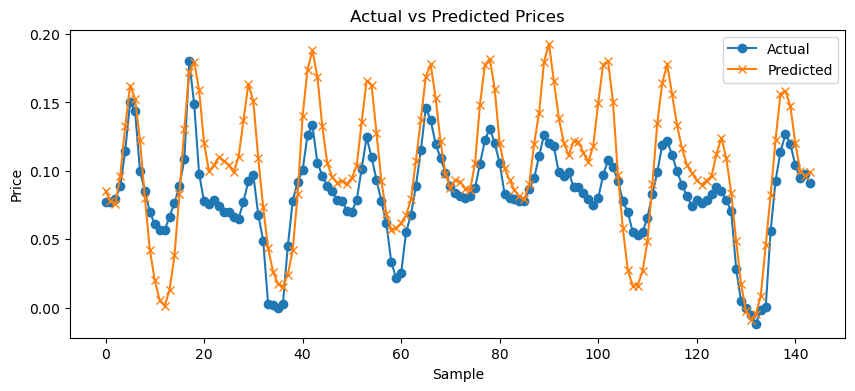

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(y_test, label='Actual', marker='o')
plt.plot(y_pred, label='Predicted', marker='x')
plt.legend()
plt.title("Actual vs Predicted Prices")
plt.xlabel("Sample")
plt.ylabel("Price")
plt.show()

Day wise prediction plot

In [35]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# === Parameters ===
start_date = pd.Timestamp("2025-03-15 00:00:00")
rolling_days = 7  # number of days to roll
horizon = 1       # forecast horizon per roll

regressors = [
    'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation',
    'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day',
    'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday_cos', 'wind_speed_10m'
]
available_regressors = [col for col in df.columns if col in regressors]

# === Storage ===
all_preds, all_actuals, all_timestamps, all_horizons = [], [], [], []
#print(f"Available regressors: {available_regressors}")
from datetime import timedelta
import numpy as np
import pandas as pd

# Ensure datetime column is correct
df['target_datetime'] = pd.to_datetime(df['target_datetime'], errors='coerce').dt.tz_localize(None)
df['target_datetime'] = df['target_datetime'].dt.normalize()

print("=" * 60)

# Rolling forecast loop
for day_offset in range(rolling_days):
    predict_date = start_date + timedelta(days=day_offset)
    
    # Filter target day
    target_day = df[df['target_datetime'] == predict_date.normalize()].copy()

    if target_day.empty:
        print(f"‚ö†Ô∏è No data found for {predict_date.date()}, skipping.")
        continue

    try:
        # Rename for Prophet format
        target_day.rename(columns={'target_datetime': 'ds', 'Price': 'y'}, inplace=True)
        target_day['ds'] = pd.to_datetime(target_day['ds']).dt.tz_localize(None)

        # Select required columns
        if available_regressors:
            cols_needed = ['ds', 'y'] + available_regressors
            future = target_day[cols_needed].copy()
            future[available_regressors] = future[available_regressors].ffill().bfill()
        else:
            future = target_day[['ds', 'y']].copy()

    
        # Predict
        forecast = model.predict(future)

        if forecast.empty:
            print(f"‚ùå Forecast returned empty DataFrame for {predict_date.date()}")
            continue

        y_true = future['y'].values
        y_pred = forecast['yhat'].values

        if len(y_pred) == 0:
            print(f"‚ö†Ô∏è No y_pred returned for {predict_date.date()}, skipping.")
            continue

        horizons = np.full_like(y_true, fill_value=day_offset, dtype=int)

        all_preds.extend(y_pred)
        all_actuals.extend(y_true)
        all_timestamps.extend(forecast['ds'].values)
        all_horizons.extend(horizons)

        print(f"‚úÖ Prediction complete for {predict_date.date()} with {len(y_pred)} rows.")

    except Exception as e:
        print(f"‚ùå Error while predicting for {predict_date.date()}: {e}")

# === Evaluation ===
if not all_preds:
    print("‚ùå No predictions were made. Check your data coverage.")
else:
    final_rmse = np.sqrt(mean_squared_error(all_actuals, all_preds))
    final_mae = mean_absolute_error(all_actuals, all_preds)
    final_r2 = r2_score(all_actuals, all_preds)

    print(f"üéØ Rolling RMSE: {final_rmse:.3f} | MAE: {final_mae:.3f} | R¬≤: {final_r2:.3f}")

    # Evaluation DataFrame
    df_eval = pd.DataFrame({
        'Timestamp': all_timestamps,
        'Actual': all_actuals,
        'Predicted': all_preds,
        'Horizon': all_horizons
    })

    # Pivot for multi-horizon view
    pivot_df = df_eval.pivot_table(index='Timestamp', columns='Horizon', values='Predicted', aggfunc='first')
    pivot_df.columns = [f'Predicted_{h+1}d_ahead' for h in pivot_df.columns]
    pivot_df.reset_index(inplace=True)

    actuals = df_eval.drop_duplicates('Timestamp')[['Timestamp', 'Actual']]
    pivot_df = pd.merge(pivot_df, actuals, on='Timestamp', how='left')

    # Horizon-wise RMSE
    horizon_rmse_log = {}
    print("üìâ Horizon-wise RMSEs:")
    for h in sorted(df_eval['Horizon'].unique()):
        df_h = df_eval[df_eval['Horizon'] == h]
        if not df_h.empty:
            rmse_h = np.sqrt(mean_squared_error(df_h['Actual'], df_h['Predicted']))
            print(f"üîπ Horizon {h+1}-step ahead ‚Üí RMSE: {rmse_h:.4f}")
            horizon_rmse_log[f"rmse_horizon_{h+1}"] = rmse_h

    print("‚úÖ Horizon-wise RMSEs plotted.")

‚úÖ Prediction complete for 2025-03-15 with 24 rows.
‚úÖ Prediction complete for 2025-03-16 with 24 rows.
‚úÖ Prediction complete for 2025-03-17 with 24 rows.
‚úÖ Prediction complete for 2025-03-18 with 24 rows.
‚úÖ Prediction complete for 2025-03-19 with 24 rows.
‚úÖ Prediction complete for 2025-03-20 with 24 rows.
‚úÖ Prediction complete for 2025-03-21 with 24 rows.
üéØ Rolling RMSE: 0.053 | MAE: 0.043 | R¬≤: -0.167
üìâ Horizon-wise RMSEs:
üîπ Horizon 1-step ahead ‚Üí RMSE: 0.0261
üîπ Horizon 2-step ahead ‚Üí RMSE: 0.0397
üîπ Horizon 3-step ahead ‚Üí RMSE: 0.0526
üîπ Horizon 4-step ahead ‚Üí RMSE: 0.0555
üîπ Horizon 5-step ahead ‚Üí RMSE: 0.0622
üîπ Horizon 6-step ahead ‚Üí RMSE: 0.0654
üîπ Horizon 7-step ahead ‚Üí RMSE: 0.0597
‚úÖ Horizon-wise RMSEs plotted.


‚ö†Ô∏è Not enough unique days to sample 4 values. Found only 1


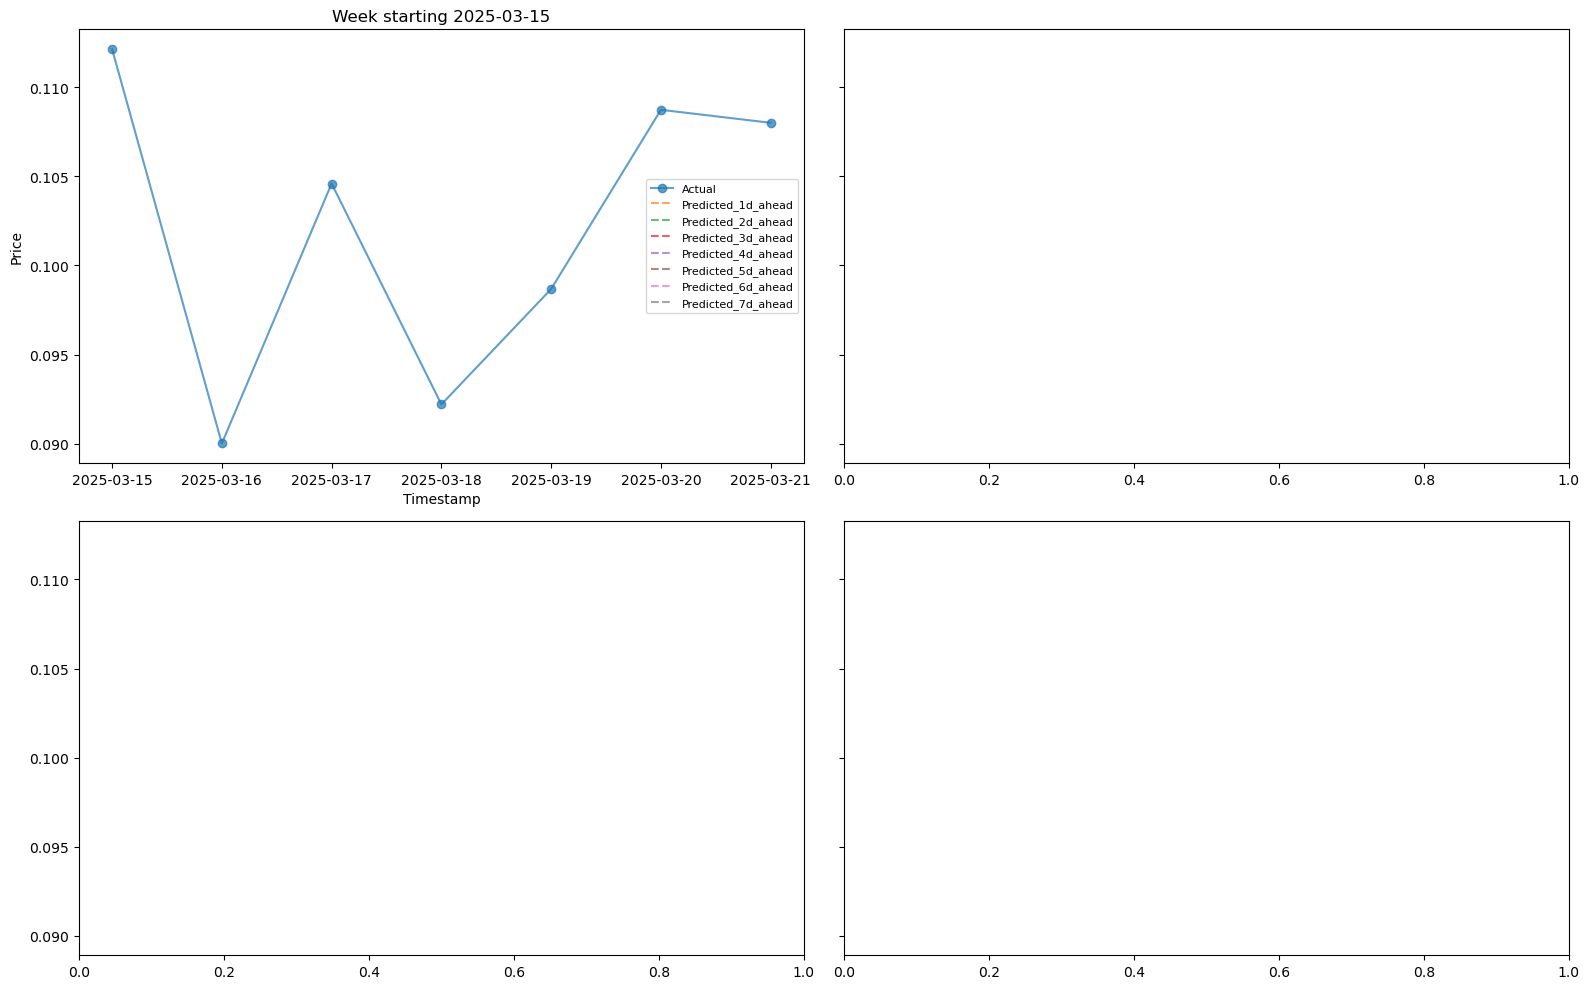

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Ensure Timestamp is datetime
pivot_df['Timestamp'] = pd.to_datetime(pivot_df['Timestamp'])

# Get unique days from Timestamp
unique_days = pivot_df['Timestamp'].dt.normalize().unique()
unique_days = np.sort(unique_days)  # Ensure chronological order

# Exclude last 6 days to allow for a 7-day window
population = unique_days[:-6]

# Sample 4 starting days (if enough)
if len(population) >= 4:
    chosen_starts = np.random.choice(population, 4, replace=False)
else:
    print(f"‚ö†Ô∏è Not enough unique days to sample 4 values. Found only {len(population)}")
    chosen_starts = population

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(16, 10), sharey=True)
axs = axs.flatten()

for i, start_day in enumerate(chosen_starts):
    mask = (pivot_df['Timestamp'] >= start_day) & (pivot_df['Timestamp'] < start_day + np.timedelta64(7, 'D'))
    week_df = pivot_df[mask]

    ax = axs[i]
    ax.plot(week_df['Timestamp'], week_df['Actual'], label='Actual', marker='o', linestyle='-', alpha=0.7)
    
    # Plot each forecast horizon
    for col in week_df.columns:
        if col.startswith('Predicted_'):
            ax.plot(week_df['Timestamp'], week_df[col], label=col, linestyle='--', alpha=0.7)
    
    ax.set_title(f"Week starting {pd.to_datetime(start_day).date()}")
    ax.set_xlabel("Timestamp")
    ax.set_ylabel("Price")
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()
